In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

# Load Moseq & Stats Dataframes

In [2]:
moseq_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq/10-29-2024_Moseq_Outputs/CSVs/moseq_df.csv')
stats_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq/10-29-2024_Moseq_Outputs/CSVs/stats_df.csv')

# Useful Functions

In [3]:
uuid_NameMap = {}
for row in moseq_df.index:
    if moseq_df['uuid'][row] not in uuid_NameMap:
        uuid_NameMap[moseq_df['uuid'][row]] = moseq_df['SessionName'][row]

In [4]:
uuid_NameMap

{'0f48182b-4ba6-4c2d-8fd4-be1a881fd666': 'LNB2_M2_050124',
 '8f9400e6-caa3-4bf2-98e6-6d5aa0fcc3aa': 'Trial 24_EE2_F1_032324',
 '7428bb33-d645-4a2d-9d22-67cf5d8628d0': 'NGH4_F1_050224',
 'ccfaa924-f6b9-4cba-9593-7d00f8c1a25e': 'Trial 6_EE1_M2_032124',
 '866d0a51-66db-4fca-b5d8-5b5ad36afd06': 'Trial 5_EE1_M1_032124',
 '1e1c84f9-a253-47ee-9442-c474d2abaaf4': 'Trial 26_EE2_F3_032324',
 '2bf838b1-f56b-4bea-9a62-11031a4bbbc7': 'Trial 39_EE4_F3_032424',
 '1c48e8c5-8b12-4a9d-9a9e-f66f29fbf5ad': 'Trial 10_SI1_M_032124',
 '14779e2d-0b48-4b7b-b579-244080019c75': 'NGH1_M4_050124',
 'd7902fa7-41f8-4fa1-b2ae-2587aa93194f': 'Trial 38_EE4_F2_032424',
 'af31b4c8-4fad-4052-9704-6dfc97eeb1c7': 'LNB3_F3_050224',
 '93420119-6b52-4545-a11b-531557475905': 'MomF',
 '78abe228-2349-43ad-bd89-50c9a5da8b66': 'MomD',
 'ee17dc12-af44-4bc8-a58e-05f9387791ed': 'Trial 31_SI4_F_032324',
 '0fe934f3-bdab-4be5-897f-75a8da179488': 'LNB1_M4_050124',
 'b837d983-a04d-49a5-b512-77026a7af2aa': 'NGH4_F3_050224',
 '134a4ba1-2e8d-

In [5]:
def rename_groups(df):
    
    """
    Function that takes a dataframe as input
    Returns the same dataframe but with a new category column
    Category column contains updated group labels accounting for different controls
    """
    
    new_cat = []
    
    for row in df.index:
        """
        if df['group'][row].split('_')[0] == 'NGH':
            NGHtype = uuid_NameMap[df['uuid'][row]]
            if NGHtype.split('_')[-1].startswith('05'):
                new_cat.append('Ctrl-LNB')
            elif NGHtype.split('_')[-1].startswith('03'):
                new_cat.append('Ctrl-EE/SI')
        else:
        """
        new_cat.append(df['group'][row].split('_')[0])

    df['category'] = new_cat
    
    return df

In [6]:
import pandas as pd
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

def run_kruskal(df, cat, ctrl):
    """
    Takes in a dataframe and two categories.
    Returns Kruskal-Wallis Score and FDR-corrected P Values for These two categories.
    """
    syllables = []
    test_statistic = []
    p_val = []

    for syl in set(df['syllable']):
        syllables.append(syl)
        kw_sub = df[df['syllable'] == syl]

        lnb_sub = kw_sub[kw_sub['category'] == cat]
        lnb_ctrl_sub = kw_sub[kw_sub['category'] == ctrl]

        # Adjust lengths if different
        if len(lnb_sub) > len(lnb_ctrl_sub):
            lnb_sub = lnb_sub.iloc[:len(lnb_ctrl_sub)]
        elif len(lnb_ctrl_sub) > len(lnb_sub):
            lnb_ctrl_sub = lnb_ctrl_sub.iloc[:len(lnb_sub)]

        # Recreate the compound DataFrame
        compound_df = pd.DataFrame(data={cat: list(lnb_sub['usage']), ctrl: list(lnb_ctrl_sub['usage'])})

        # Check if all numbers are identical
        if len(set(compound_df[cat])) == 1 and len(set(compound_df[ctrl])) == 1:
            print(f"Skipping syllable {syl} as all numbers are identical in both groups.")
            test_statistic.append(float('nan'))
            p_val.append(float('nan'))
            continue
        
        # Perform Kruskal-Wallis test
        statistic, p_value = kruskal(compound_df[cat], compound_df[ctrl])

        test_statistic.append(statistic)
        p_val.append(p_value)
        
    # Apply FDR correction using the Benjamini-Hochberg method
    _, p_val_corrected, _, _ = multipletests(p_val, method='fdr_bh')

    return_df = pd.DataFrame(data={
        'Syllable': syllables, 
        'Kruskal-Wallis Test Stat': test_statistic, 
        'P_Value': p_val,
    })

    return_df = return_df.dropna(subset='P_Value')

    #FDR correction using the Benjamini-Hochberg method
    _, p_val_corrected, _, _ = multipletests(list(return_df['P_Value']), method='fdr_bh')

    return_df['FDR_Corrected_P_Value'] = p_val_corrected

    
    # Filter and reset index based on the corrected p-values
    return return_df[return_df['P_Value'] <= 0.20].reset_index(drop=True)

# Example of how to run the function
# result = run_kruskal(male_stats, 'LNB', 'Ctrl-LNB')


In [7]:
def reformat_df(subset_df, metric_interest):
    """
    Take multi-index summary dataframe from Moseq fingerprint code as well as a metric of interest
    Reformat into single index dataframe for further analysis
    Returns dataframe with category label, position, uuid, and avg_time for that uuid in that metric
    """

    category = []
    position = []
    uuid_num = []
    avg_time = []
    
    for ix in subset_df[metric_interest]:
        for cat, uuid in subset_df[metric_interest][ix].index:
            category.append(cat)
            position.append(ix)
            uuid_num.append(uuid)
            avg_time.append(subset_df[metric_interest][ix][cat][uuid])
    
    
    return rename_groups(pd.DataFrame(data={'group': category, 'Metric': position, 'uuid': uuid_num, 'avg_time': avg_time}))


In [8]:
def pairwise_plots(df, plot_type, Title, X_label, Y_label, stat_test, x_range=[0, 100], save_dir='/om2/user/mabdel03/files/BTI/Moseq/10-30-24_Moms_Meeting/Figures'):
    """
    Function to produce pairwise plots of the data on a single panel
    Takes in a dataframe with
    plot_type is a tuple of (x variable, y variable)
    """
    #categories = [('EE', 'Ctrl-EE/SI'), ('SI', 'Ctrl-EE/SI'), ('LNB', 'Ctrl-LNB')]
    categories = [('LNB', 'NGH')]
    subs = {'EE': '', 'SI': '', 'LNB': ''}

    x_var, y_var = plot_type

    # Define a color palette where 'cat' is always blue and 'ctrl' is always orange
    custom_palette = {'EE': 'red', 'NGH': 'green', 'SI': 'red', 'LNB': 'red', 'NGH': 'green'}
    
    # Create a figure with subplots
    fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories
    
    for i, (cat, ctrl) in enumerate(categories):
        
        subs[cat] = df[(df['category'] == cat) | (df['category'] == ctrl)]

        """
        if stat_test == 'kruskal':
            p_values_df = run_kruskal(subs[cat], cat, ctrl)
            p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
            suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
            root = os.path.join(save_dir, suffix)
            p_values_df_sub.to_csv(root)

        if stat_test == 'mann-whit':
            boring_mann_whit(subs[cat], cat, ctrl, x_var, y_var)
            p_values_df = mann_whit(subs[cat], cat, ctrl, x_var, y_var)
            p_values_df.to_csv(os.path.join(save_dir, f'{x_var}.csv'))
        """
        
        # Plot the line plot on the corresponding subplot
        sns.lineplot(ax=axes, data=subs[cat], x=x_var, y=y_var, hue='category', palette=custom_palette)
        ticks = range(0, len(subs[cat][x_var].unique()), 5)  # Define your ticks
        # Set the x-ticks for the specific subplot
        axes.set_xticks(ticks)
        
        axes.set_title(f'{cat} vs. {ctrl}')
        axes.set_xlabel(X_label)
        axes.set_ylabel(Y_label)
        axes.set_xlim(x_range)
        axes.tick_params(axis='x', rotation=45)  # Rotate labels if needed
        """
        if stat_test == 'kruskal':
            for _, row in p_values_df.iterrows():
                if row['FDR_Corrected_P_Value'] <= 0.05:
                    syllable = row['Syllable']
                    # Get the y-position for the annotation (place above the maximum y value for that syllable)
                    max_y = subs[cat][subs[cat][x_var] == syllable][y_var].max()
                    axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

        if stat_test == 'mann-whit':
            for _, row in p_values_df.iterrows():
                if row['P-Value'] <= 0.05:
                    x_met = row['Metric']
                    # Get the y-position for the annotation (place above the maximum y value for that syllable)
                    max_y = subs[cat][subs[cat]['Metric'] == x_met][y_var].max()
                    axes[i].text(x_met, max_y - 0.001, '*', ha='center', va='bottom', color='black', fontsize=12)
        """
    # Add an overall title for the entire figure
    plt.suptitle(Title, fontsize=16)
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title
    
    plt.savefig(os.path.join(save_dir, f'{x_var}.png'), dpi=300)
    
    plt.show()

In [9]:
from scipy.stats import mannwhitneyu
def mann_whit(df, cat, ctrl, x_lab, y_lab):
    # Get unique positions (metrics)
    positions = df[y_lab].unique()
    
    # Initialize a list to store the results
    results = []
    
    # Iterate through each position
    for position in positions:
        # Filter the data for the current position
        position_data = df[df[y_lab] == position]
        
        # Group data by category
        category_groups = position_data.groupby('group')[x_lab].apply(list)
        
        if cat in category_groups and ctrl in category_groups:
            data_EE = category_groups[cat]
            data_SI = category_groups[ctrl]
            
            stat, p_value = mannwhitneyu(data_EE, data_SI)
            test_name = 'Mann-Whitney U test'
            
            # Append the result for the current position
            results.append({
                'Metric': position,
                'Test': test_name,
                'Statistic': stat,
                'P-Value': p_value
            })
    
    # Convert results to a DataFrame for easy viewing
    results_df = pd.DataFrame(results)

    
    #results_df = results_df.dropna(subset='P-Value')
    
    # Apply FDR (Benjamini-Hochberg) correction
    reject, pvals_corrected, _, _ = multipletests(results_df['P-Value'], method='fdr_bh')
    
    # Add the corrected p-values to the DataFrame
    results_df['FDR_Corrected_P'] = pvals_corrected
    
    return results_df[results_df['P-Value'] <= 0.1]
    


In [10]:
from scipy.stats import mannwhitneyu

def boring_mann_whit(df, cat, ctrl, x_lab, y_lab):
    
    # Step 1: Aggregate data by uuid within each category
    aggregated_df = df.groupby(['category', 'uuid'])[y_lab].mean().reset_index()
    
    # Step 2: Filter the data for the two categories
    group_EE = aggregated_df[aggregated_df['category'] == cat][y_lab]
    group_SI = aggregated_df[aggregated_df['category'] == ctrl][y_lab]
    
    # Ensure both groups have data
    if len(group_EE) > 0 and len(group_SI) > 0:
        # Perform the Mann-Whitney U test on the aggregated data
        stat, p_value = mannwhitneyu(group_EE, group_SI, alternative='two-sided')
        
        # Display the result
        print(f'Mann-Whitney U Statistic: {stat}')
        print(f'P-Value: {p_value}')

# Subsetting Dataframes And Reorganizing--Male/Female, Relabeling NGH

In [63]:
stats_Moms = stats_df[stats_df['group'].apply(lambda x: x.split('_')[1] == 'Mom')]

In [64]:
moseq_Moms = moseq_df[moseq_df['group'].apply(lambda x: x.split('_')[1] == 'Mom')]

In [65]:
#male_stats = stats_NoMoms[stats_NoMoms['group'].apply(lambda x: x.split('_')[2] == 'Male')]

In [66]:
#female_stats = stats_NoMoms[stats_NoMoms['group'].apply(lambda x: x.split('_')[2] == 'Female')]

In [67]:
male_cat = []
for row in stats_Moms.index:
    male_cat.append(stats_Moms['group'][row].split('_')[0])

In [68]:
stats_Moms['category'] = male_cat

/tmp/ipykernel_53048/2149331605.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_Moms['category'] = male_cat


In [69]:
stats_Moms = stats_Moms.reset_index()

In [70]:
stats_Moms

index           group                                  uuid  syllable  \
0       14  LNB_Mom_Female  12d495ba-4ee8-4cc8-8c1c-952e10524373         0   
1       15  LNB_Mom_Female  289c6a24-0e94-453f-bbf8-6527bb2391f9         0   
2       16  LNB_Mom_Female  5dc81e1d-d174-4a10-a53e-d66f5fe10b83         0   
3       17  LNB_Mom_Female  7cc31277-f7df-47e8-853f-6c164bfa1897         0   
4       18  LNB_Mom_Female  b87c8a82-8485-47e2-b39a-fd0efcdd1bdb         0   
..     ...             ...                                   ...       ...   
710   4894  NGH_Mom_Female  51502afd-9dec-46f8-b73d-1c73baf1bfe2        64   
711   4895  NGH_Mom_Female  78abe228-2349-43ad-bd89-50c9a5da8b66        64   
712   4896  NGH_Mom_Female  93420119-6b52-4545-a11b-531557475905        64   
713   4897  NGH_Mom_Female  e8869e74-712a-4705-8198-7ed46e563f29        64   
714   4898  NGH_Mom_Female  eb1ccbfc-e6fc-4bac-8289-9c748e9c9ed4        64   

        usage  duration  frame index_mean  frame index_std  frame index_min  \
0    0.021103  0.268939         21455.701     10909.264000            670.0   
1    0.031615  0.319178         14363.246      8755.561000            140.0   
2    0.022827  0.339716         19525.965      7721.277300           2653.0   
3    0.049975  0.368367         18381.613      8300.569000            963.0   
4    0.041750  0.341346         20926.045      9147.020500           1458.0   
..        ...       ...               ...              ...              ...   
710  0.000000       NaN               NaN              NaN              NaN   
711  0.000000       NaN               NaN              NaN              NaN   
712  0.000000       NaN               NaN              NaN              NaN   
713  0.000000       NaN               NaN              NaN              NaN   
714  0.000508  0.900000           467.000         7.937254            454.0   

     frame index_max  ...  dist_to_center_px_mean  dist_to_center_px_std  \
0            35524.0  ...                74.66489              22.146582   
1            35132.0  ...                77.70760              18.879786   
2            35856.0  ...                86.36679              12.877293   
3            35924.0  ...                81.58117              19.179674   
4            35511.0  ...                87.82068              18.354656   
..               ...  ...                     ...                    ...   
710              NaN  ...                     NaN                    NaN   
711              NaN  ...                     NaN                    NaN   
712              NaN  ...                     NaN                    NaN   
713              NaN  ...                     NaN                    NaN   
714            480.0  ...               106.61462               1.046811   

     dist_to_center_px_min  dist_to_center_px_max  timestamps_mean  \
0                19.350252             103.653020     6.354429e+08   
1                33.606660             104.145340     5.939434e+05   
2                29.017124             105.289276     1.161308e+07   
3                15.455030             105.834470     8.249688e+06   
4                10.447676             106.166970     1.363580e+07   
..                     ...                    ...              ...   
710                    NaN                    NaN              NaN   
711                    NaN                    NaN              NaN   
712                    NaN                    NaN              NaN   
713                    NaN                    NaN              NaN   
714             103.615776             107.817730     1.755987e+06   

     timestamps_std  timestamps_min  timestamps_max         syllable key  \
0     363642.048576    6.347501e+08    6.359119e+08  labels (usage sort)   
1     291851.985587    1.198355e+05    1.286235e+06  labels (usage sort)   
2     257605.517347    1.105044e+07    1.215797e+07  labels (usage sort)   
3     276686.039010    7.669066e+06    8.834435e+06  labels (

In [29]:
"""
Pairwise Comparisons:
EE vs. NGH-EE/SI
SI vs NGH-EE/SI
LNB vs NGH-LNB
"""

'\nPairwise Comparisons:\nEE vs. NGH-EE/SI\nSI vs NGH-EE/SI\nLNB vs NGH-LNB\n'

# Syllable Usage Analysis

In [71]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy.stats import f_oneway
from statsmodels.multivariate.manova import MANOVA

### Mom Plots & Stats

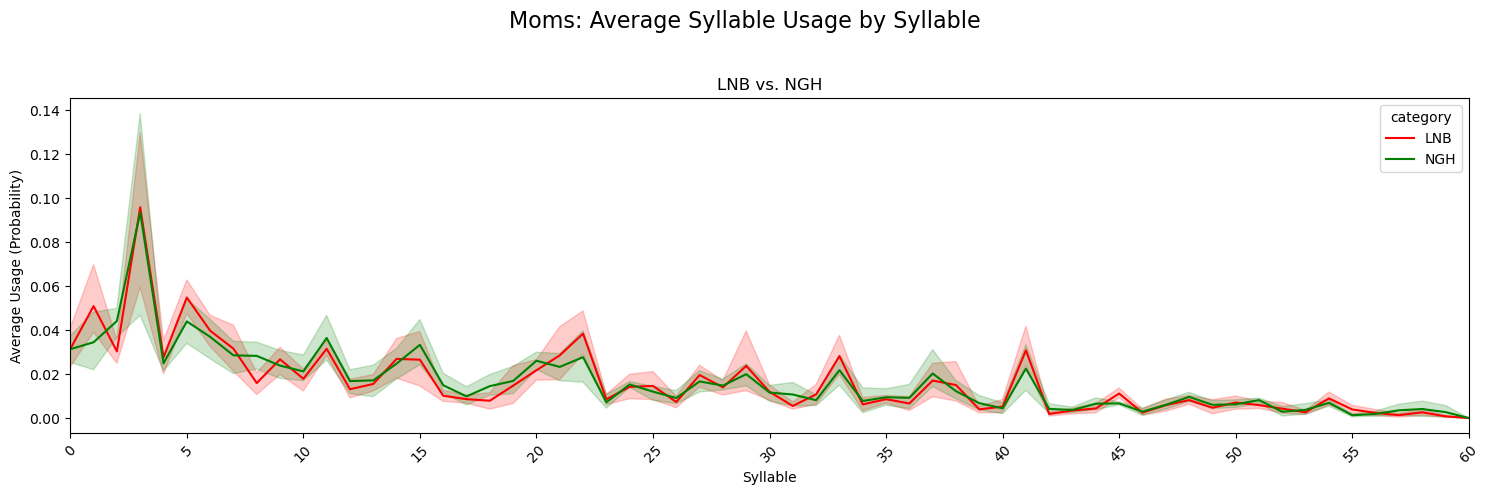

In [84]:
pairwise_plots(stats_Moms, ('syllable', 'usage'), 'Moms: Average Syllable Usage by Syllable', 'Syllable', 'Average Usage (Probability)', 'mann-whit', x_range=[0, 60], save_dir='/om2/user/mabdel03/files/BTI/Moseq/10-30-24_Moms_Meeting/Figures')

#### EE Vs. SI and LNB

Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.
Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.


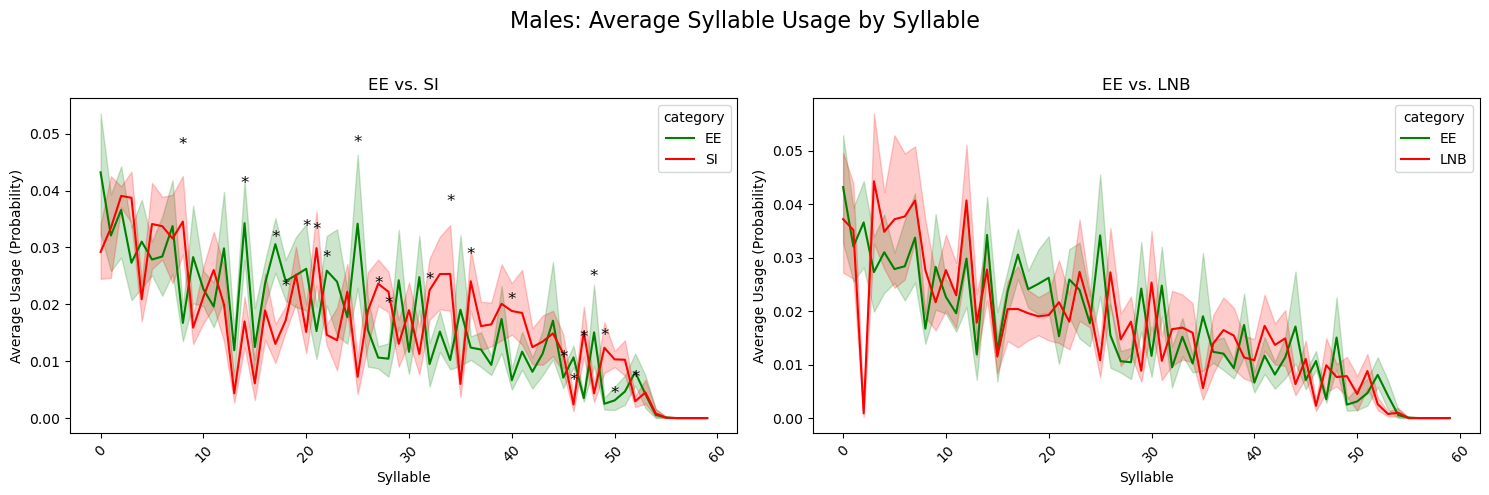

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'SI'), ('EE', 'LNB')]
male_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'green', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    male_subs[cat] = male_stats[(male_stats['category'] == cat) | (male_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=male_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(male_subs[cat], cat, ctrl)
    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Males', suffix)
    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=male_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    #P_Value
    #FDR_Corrected_P_Value
    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Males: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig(f'/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Male_EE-Condition_syllable_usage.png', dpi=300)

plt.show()


#### Normal Comparisons (Condition vs. Controls)

Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.
Skipping syllable 55 as all numbers are identical in both groups.
Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.


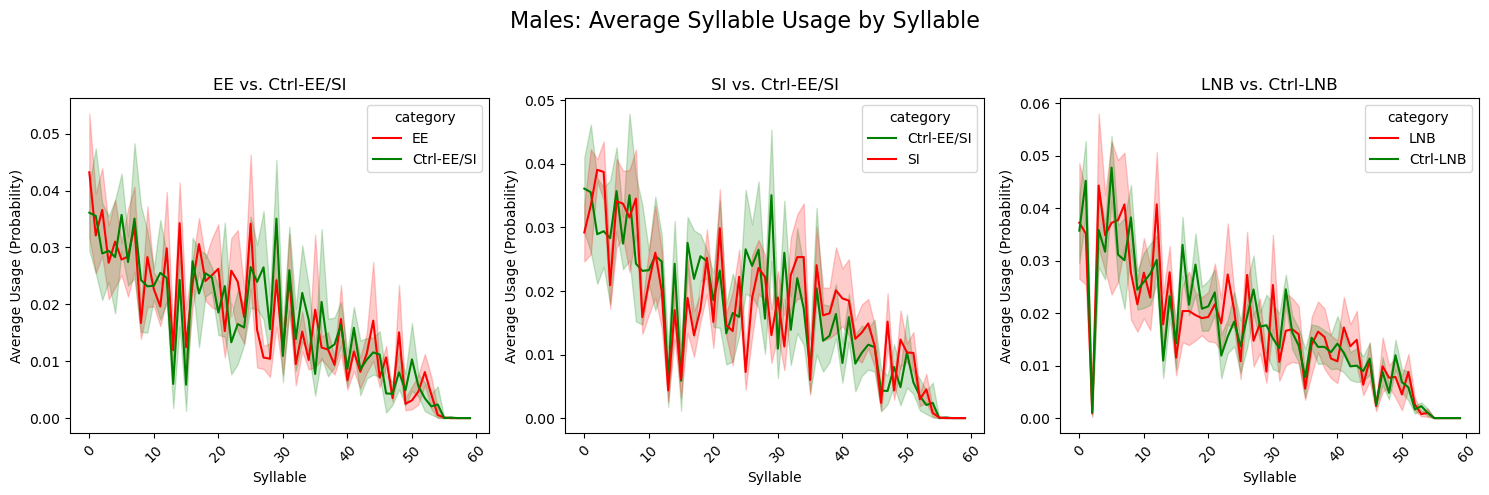

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'Ctrl-EE/SI'), ('SI', 'Ctrl-EE/SI'), ('LNB', 'Ctrl-LNB')]
male_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'red', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    male_subs[cat] = male_stats[(male_stats['category'] == cat) | (male_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=male_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(male_subs[cat], cat, ctrl)
    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Males', suffix)
    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=male_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Males: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Male_average_syllable_usage.png', dpi=300)

plt.show()


### Control Comparisons (Male and Female)

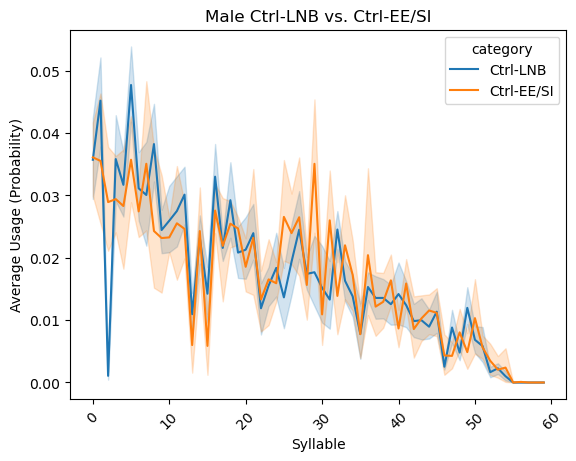

In [34]:
ctrl_sub = male_stats[(male_stats['category'] == 'Ctrl-LNB') | (male_stats['category'] == 'Ctrl-EE/SI')]
sns.lineplot(data=ctrl_sub, x='syllable', y='usage', hue='category')

plt.title('Male Ctrl-LNB vs. Ctrl-EE/SI')
plt.xlabel('Syllable')
plt.ylabel('Average Usage (Probability)')
plt.tick_params(axis='x', rotation=45)  # Rotate labels if needed

plt.show()

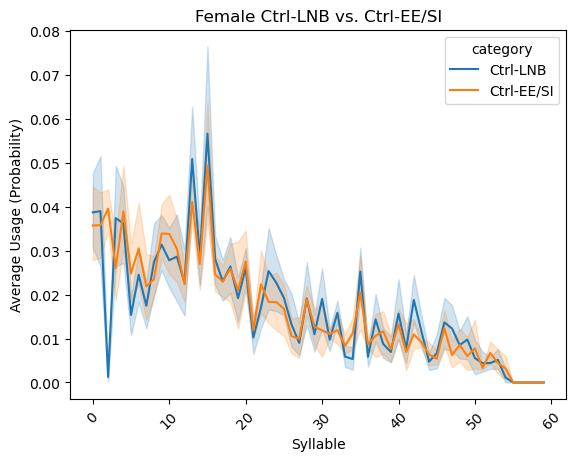

In [35]:
ctrl_sub = female_stats[(female_stats['category'] == 'Ctrl-LNB') | (female_stats['category'] == 'Ctrl-EE/SI')]
sns.lineplot(data=ctrl_sub, x='syllable', y='usage', hue='category')

plt.title('Female Ctrl-LNB vs. Ctrl-EE/SI')
plt.xlabel('Syllable')
plt.ylabel('Average Usage (Probability)')
plt.tick_params(axis='x', rotation=45)  # Rotate labels if needed

plt.show()

### Female Plots and Stats

#### EE Vs Conditions

Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.
Skipping syllable 55 as all numbers are identical in both groups.
Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.


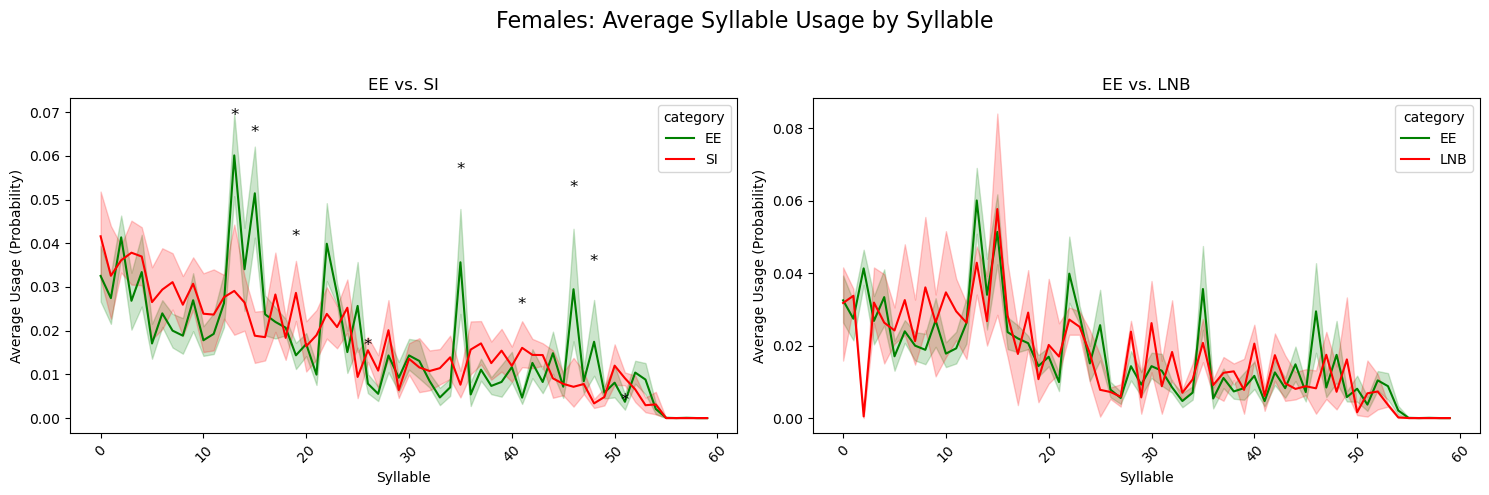

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'SI'), ('EE', 'LNB')]
male_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'green', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    male_subs[cat] = female_stats[(female_stats['category'] == cat) | (female_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=male_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(male_subs[cat], cat, ctrl)
    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]
    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'
    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Males', suffix)
    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=male_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    #P_Value
    #FDR_Corrected_P_Value
    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.01, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Females: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig(f'/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Female_EE-Condition_syllable_usage.png', dpi=300)

plt.show()


#### Conditions Vs. Controls

Skipping syllable 55 as all numbers are identical in both groups.
Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 55 as all numbers are identical in both groups.
Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 55 as all numbers are identical in both groups.
Skipping syllable 56 as all numbers are identical in both groups.
Skipping syllable 57 as all numbers are identical in both groups.
Skipping syllable 58 as all numbers are identical in both groups.
Skipping syllable 59 as all numbers are identical in both groups.


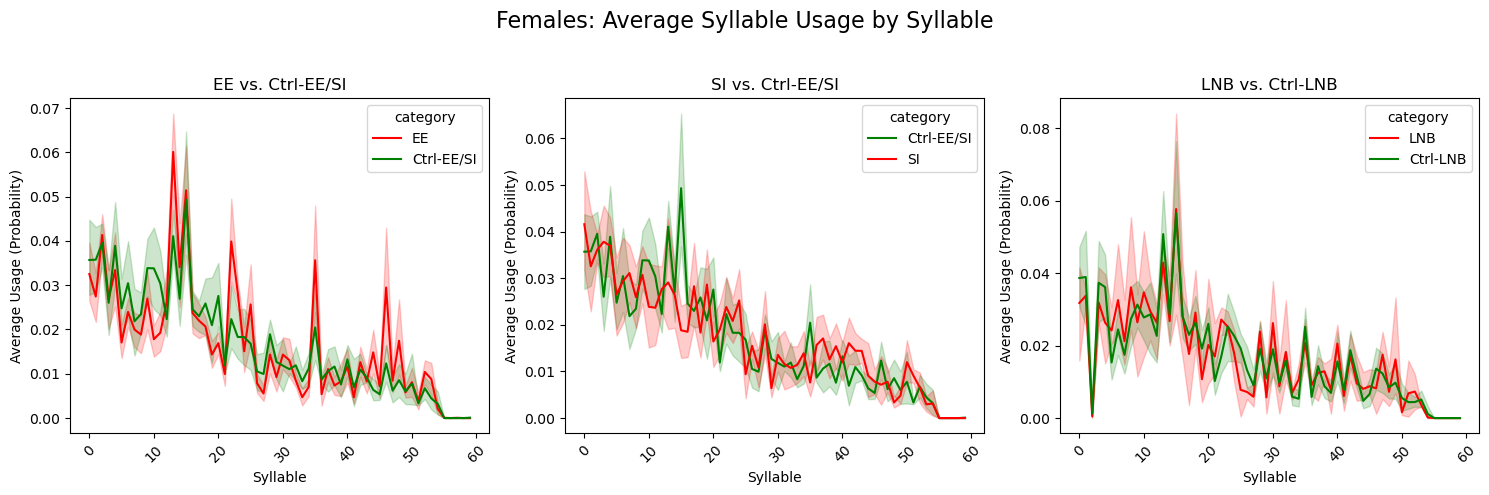

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

categories = [('EE', 'Ctrl-EE/SI'), ('SI', 'Ctrl-EE/SI'), ('LNB', 'Ctrl-LNB')]
female_subs = {'EE': '', 'SI': '', 'LNB': ''}

# Define a color palette where 'cat' is always blue and 'ctrl' is always orange
custom_palette = {'EE': 'red', 'Ctrl-EE/SI': 'green', 'SI': 'red', 'LNB': 'red', 'Ctrl-LNB': 'green'}

# Create a figure with subplots
fig, axes = plt.subplots(1, len(categories), figsize=(15, 5))  # Adjust the number of columns based on the number of categories

for i, (cat, ctrl) in enumerate(categories):
    female_subs[cat] = female_stats[(female_stats['category'] == cat) | (female_stats['category'] == ctrl)]

    # Fit the two-way ANOVA model
    model = ols('usage ~ C(syllable) * C(category)', data=female_subs[cat]).fit()

    # Separate the data into two groups based on the category
    cat_usage = male_subs[cat][male_subs[cat]['category'] == cat]['usage']
    ctrl_usage = male_subs[cat][male_subs[cat]['category'] == ctrl]['usage']

    """
    # Perform the Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(cat_usage, ctrl_usage)
    print(f"U-statistic: {u_stat}, P-value: {p_value}")

    f_stat, p_value = f_oneway(cat_usage, ctrl_usage)
    print(f"F-statistic: {f_stat}, P-value: {p_value}")

    """

    """
    # Perform ANOVA
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(cat + ' vs. ' + ctrl)
    print(anova_table)
    print('\n')

    """

    p_values_df = run_kruskal(female_subs[cat], cat, ctrl)

    p_values_df_sub = p_values_df[p_values_df['P_Value'] <= 0.05]

    suffix = cat + '_'+ ctrl.split('/')[0] + '.csv'

    root = os.path.join('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Supp_Tables/Syllable_Usage/Females', suffix)

    p_values_df_sub.to_csv(root)

    # Plot the line plot on the corresponding subplot
    sns.lineplot(ax=axes[i], data=female_subs[cat], x='syllable', y='usage', hue='category', palette=custom_palette)
    axes[i].set_title(f'{cat} vs. {ctrl}')
    axes[i].set_xlabel('Syllable')
    axes[i].set_ylabel('Average Usage (Probability)')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels if needed

    for _, row in p_values_df.iterrows():
        if row['FDR_Corrected_P_Value'] <= 0.05:
            syllable = row['Syllable']
            # Get the y-position for the annotation (place above the maximum y value for that syllable)
            max_y = male_subs[cat][male_subs[cat]['syllable'] == syllable]['usage'].max()
            axes[i].text(syllable, max_y - 0.0001, '*', ha='center', va='bottom', color='black', fontsize=12)

# Add an overall title for the entire figure
plt.suptitle('Females: Average Syllable Usage by Syllable', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the rect parameter to leave space for the title

plt.savefig('/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Syllable_Usage/Female_average_syllable_usage.png', dpi=300)

plt.show()


# Fingerprint Analysis

## Load and Format Dataframes

In [3]:
summary_df = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Fingerprints/DFs/Full/summary.csv', index_col=[0, 1], header=[0, 1])
range_dict = pd.read_csv('/om2/user/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Fingerprints/DFs/Full/range_dict.csv')

In [4]:
Moms_df = summary_df[summary_df.index.get_level_values('group').str.contains('Mom')]

In [5]:
#males_df = noMoms_df[noMoms_df.index.get_level_values('group').str.endswith('Male')]
#females_df = noMoms_df[noMoms_df.index.get_level_values('group').str.endswith('Female')]

In [9]:
range_dict #.info()

velocity_2d_mm  height_ave_mm   length_mm  dist_to_center_px     MoSeq
0        0.000000       0.000000   11.514167           0.107258  0.000000
1     6989.378906      78.069069  116.068459         126.911171  0.156236

In [7]:
Moms_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11 entries, ('LNB_Mom_Female', '12fc2b40-79c3-45fc-862d-3a4a770676bd') to ('NGH_Mom_Female', 'ff6c56ed-4528-46f7-97fe-934567b0aece')
Columns: 456 entries, ('dist_to_center_px', '0') to ('MoSeq', '59')
dtypes: float64(456)
memory usage: 42.3+ KB


In [17]:
Moms_df

dist_to_center_px  \
bin                                                                 0   
group          uuid                                                     
LNB_Mom_Female 12fc2b40-79c3-45fc-862d-3a4a770676bd          0.000111   
               2bf96938-6122-49c7-b250-b94322c8b762          0.000139   
               50fd9290-c498-4ca2-9929-49a38b6c8ffb          0.000056   
               65a73784-3905-4022-a7ec-8b608e42f823          0.000056   
               9e157199-4e46-4856-9989-7b5502504fa2          0.000139   
               f184448f-cc54-4120-9a01-2b62f428f2bb          0.000000   
NGH_Mom_Female 01b7b197-f8e9-4cc8-934a-9652d1746229          0.000000   
               0650491b-b1e2-4672-8db2-b9fd33212de2          0.000056   
               14f65e3b-f058-4657-81a6-35e5e4cbd5fe          0.000056   
               b192a588-2324-4254-9db5-01a17f4f67dc          0.000028   
               ff6c56ed-4528-46f7-97fe-934567b0aece          0.000250   

                                                                         \
bin                                                         1         2   
group          uuid                                                       
LNB_Mom_Female 12fc2b40-79c3-45fc-862d-3a4a770676bd  0.000334  0.000807   
               2bf96938-6122-49c7-b250-b94322c8b762  0.000111  0.000389   
               50fd9290-c498-4ca2-9929-49a38b6c8ffb  0.000334  0.000334   
               65a73784-3905-4022-a7ec-8b608e42f823  0.000056  0.000223   
               9e157199-4e46-4856-9989-7b5502504fa2  0.000083  0.000278   
               f184448f-cc54-4120-9a01-2b62f428f2bb  0.000000  0.000028   
NGH_Mom_Female 01b7b197-f8e9-4cc8-934a-9652d1746229  0.000167  0.000083   
               0650491b-b1e2-4672-8db2-b9fd33212de2  0.000000  0.000445   
               14f65e3b-f058-4657-81a6-35e5e4cbd5fe  0.000111  0.000222   
               b192a588-2324-4254-9db5-01a17f4f67dc  0.000139  0.000195   
               ff6c56ed-4528-46f7-97fe-934567b0aece  0.000612  0.000334   

                                                                         \
bin                                                         3         4   
group          uuid                                                       
LNB_Mom_Female 12fc2b40-79c3-45fc-862d-3a4a770676bd  0.001335  0.001085   
               2bf96938-6122-49c7-b250-b94322c8b762  0.000723  0.000640   
               50fd9290-c498-4ca2-9929-49a38b6c8ffb  0.000445  0.000612   
               65a73784-3905-4022-a7ec-8b608e42f823  0.000445  0.000223   
               9e157199-4e46-4856-9989-7b5502504fa2  0.000362  0.000667   
               f184448f-cc54-4120-9a01-2b62f428f2bb  0.000222  0.000278   
NGH_Mom_Female 01b7b197-f8e9-4cc8-934a-9652d1746229  0.000528  0.000862   
               0650491b-b1e2-4672-8db2-b9fd33212de2  0.002335  0.000890   
               14f65e3b-f058-4657-81a6-35e5e4cbd5fe  0.000250  0.000389   
               b192a588-2324-4254-9db5-01a17f4f67dc  0.000362  0.000417   
               ff6c56ed-4528-46f7-97fe-934567b0aece  0.000862  0.001780   

                                                                         \
bin                                                         5         6   
group          uuid                                                       
LNB_Mom_Female 12fc2b40-79c3-45fc-862d-3a4a770676bd  0.000807  0.000807   
               2bf96938-6122-49c7-b250-b94322c8b762  0.000779  0.000890   
               50fd9290-c498-4ca2-9929-49a38b6c8ffb  0.000612  0.000973   
               65a73784-3905-4022-a7ec-8b608e42f823  0.000306  0.000501   
               9e157199-4e46-4856-9989-7b5502504fa2  0.000445  0.000695   
               f184448f-cc54-4120-9a01-2b62f428f2bb  0.000445  0.000750   
NGH_Mom_Female 01b7b197-f8e9-4cc8-934a-9652d1746229  0.000556  0.000528   
               0650491b-b1e2-4672-8db2-b9fd33212de2  0.000751  0.000556   
               14f65e3b-f058-4657-81a6-35e5e4cbd5fe  0.000612  0.001891   
               b192a588-232

In [16]:
print(Moms_df)

                                                    dist_to_center_px  \
bin                                                                 0   
group          uuid                                                     
LNB_Mom_Female 12fc2b40-79c3-45fc-862d-3a4a770676bd          0.000111   
               2bf96938-6122-49c7-b250-b94322c8b762          0.000139   
               50fd9290-c498-4ca2-9929-49a38b6c8ffb          0.000056   
               65a73784-3905-4022-a7ec-8b608e42f823          0.000056   
               9e157199-4e46-4856-9989-7b5502504fa2          0.000139   
               f184448f-cc54-4120-9a01-2b62f428f2bb          0.000000   
NGH_Mom_Female 01b7b197-f8e9-4cc8-934a-9652d1746229          0.000000   
               0650491b-b1e2-4672-8db2-b9fd33212de2          0.000056   
               14f65e3b-f058-4657-81a6-35e5e4cbd5fe          0.000056   
               b192a588-2324-4254-9db5-01a17f4f67dc          0.000028   
               ff6c56ed-4528-46f7-97fe-934567b0aece

In [90]:
list(set(column[0] for column in summary_df.columns))

['MoSeq', 'length_mm', 'dist_to_center_px', 'height_ave_mm', 'velocity_2d_mm']

## Position

In [101]:
root = '/net/vast-storage/scratch/vast/lhtsai/mabdel03/files/BTI/Moseq/SuperCoolMeeting_I/Figures/Scalars/Position'

### Males

In [14]:
m_pos_df = reformat_df(Moms_df, 'dist_to_center_px')
m_pos_df = rename_groups(m_pos_df)

In [15]:
m_pos_df

group Metric                                  uuid  avg_time  \
0     LNB_Mom_Female      0  12fc2b40-79c3-45fc-862d-3a4a770676bd  0.000111   
1     LNB_Mom_Female      0  2bf96938-6122-49c7-b250-b94322c8b762  0.000139   
2     LNB_Mom_Female      0  50fd9290-c498-4ca2-9929-49a38b6c8ffb  0.000056   
3     LNB_Mom_Female      0  65a73784-3905-4022-a7ec-8b608e42f823  0.000056   
4     LNB_Mom_Female      0  9e157199-4e46-4856-9989-7b5502504fa2  0.000139   
...              ...    ...                                   ...       ...   
1084  NGH_Mom_Female     98  01b7b197-f8e9-4cc8-934a-9652d1746229  0.000000   
1085  NGH_Mom_Female     98  0650491b-b1e2-4672-8db2-b9fd33212de2  0.000000   
1086  NGH_Mom_Female     98  14f65e3b-f058-4657-81a6-35e5e4cbd5fe  0.000000   
1087  NGH_Mom_Female     98  b192a588-2324-4254-9db5-01a17f4f67dc  0.000000   
1088  NGH_Mom_Female     98  ff6c56ed-4528-46f7-97fe-934567b0aece  0.000000   

     category  
0         LNB  
1         LNB  
2         LNB  
3         LNB  
4         LNB  
...       ...  
1084      NGH  
1085      NGH  
1086      NGH  
1087      NGH  
1088      NGH  

[1089 rows x 5 columns]

In [103]:
save_dir = os.path.join(root, 'Moms')

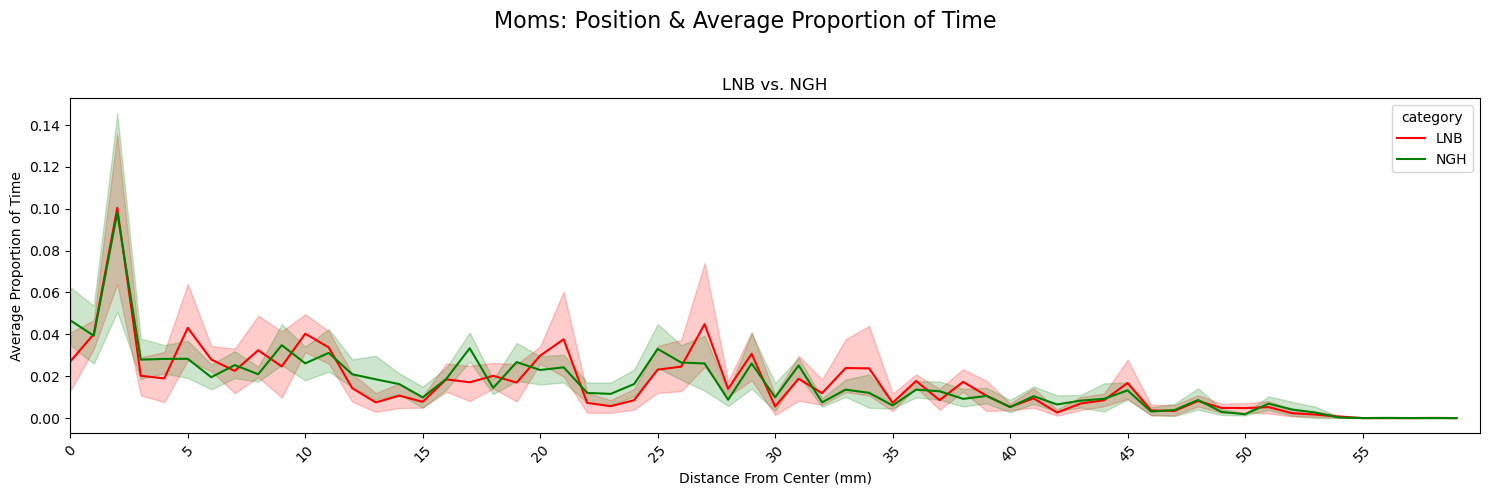

In [128]:
#(df, plot_type, Title, X_label, Y_label, stat_test)
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Moms: Position & Average Proportion of Time', 'Distance From Center (mm)', 'Average Proportion of Time', 'mann-whit', [0, 60], '/om2/user/mabdel03/files/BTI/Moseq/10-30-24_Moms_Meeting/Figures')

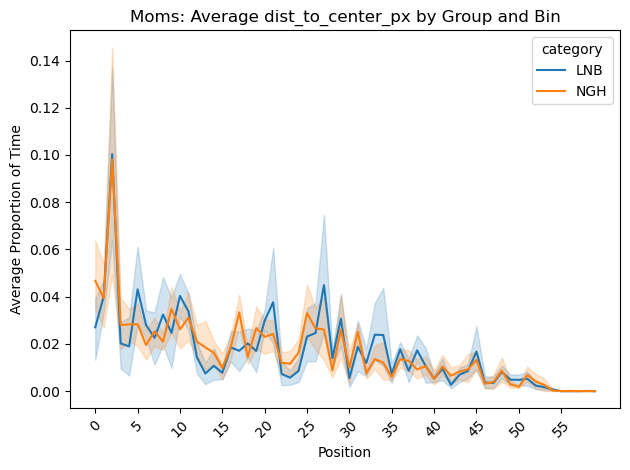

In [125]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 5))
# Customize the plot
plt.title('Moms: Average dist_to_center_px by Group and Bin')
plt.xlabel('Position')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

In [46]:
f_pos_df = reformat_df(females_df, 'dist_to_center_px')
f_pos_df = rename_groups(f_pos_df)
save_dir = os.path.join(root, 'Females')

Mann-Whitney U Statistic: 33.0
P-Value: 0.2823842823842824
Mann-Whitney U Statistic: 16.0
P-Value: 0.344988344988345
Mann-Whitney U Statistic: 12.0
P-Value: 0.8333333333333333


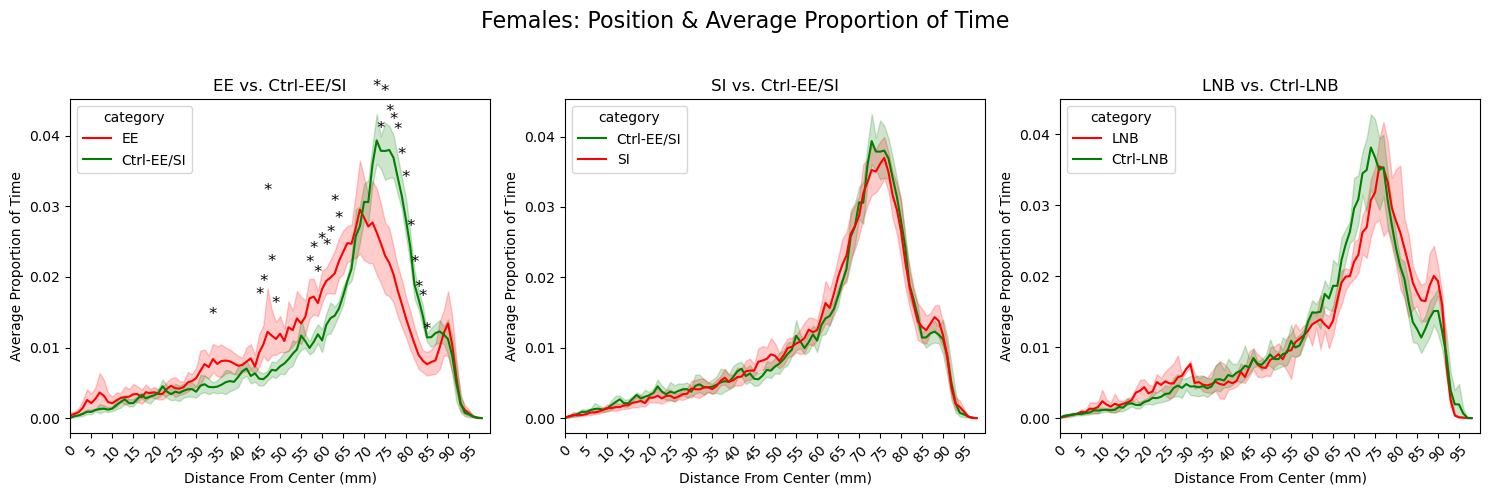

In [47]:
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Position & Average Proportion of Time', 'Distance From Center (mm)', 'Average Proportion of Time', 'mann-whit', [0, 100], save_dir)

## Velocity

In [107]:
root = '/om2/user/mabdel03/files/BTI/Moseq/10-30-24_Moms_Meeting/Figures'

### Males

In [108]:
m_pos_df = reformat_df(Moms_df, 'velocity_2d_mm')
m_pos_df = rename_groups(m_pos_df)

In [109]:
save_dir = root

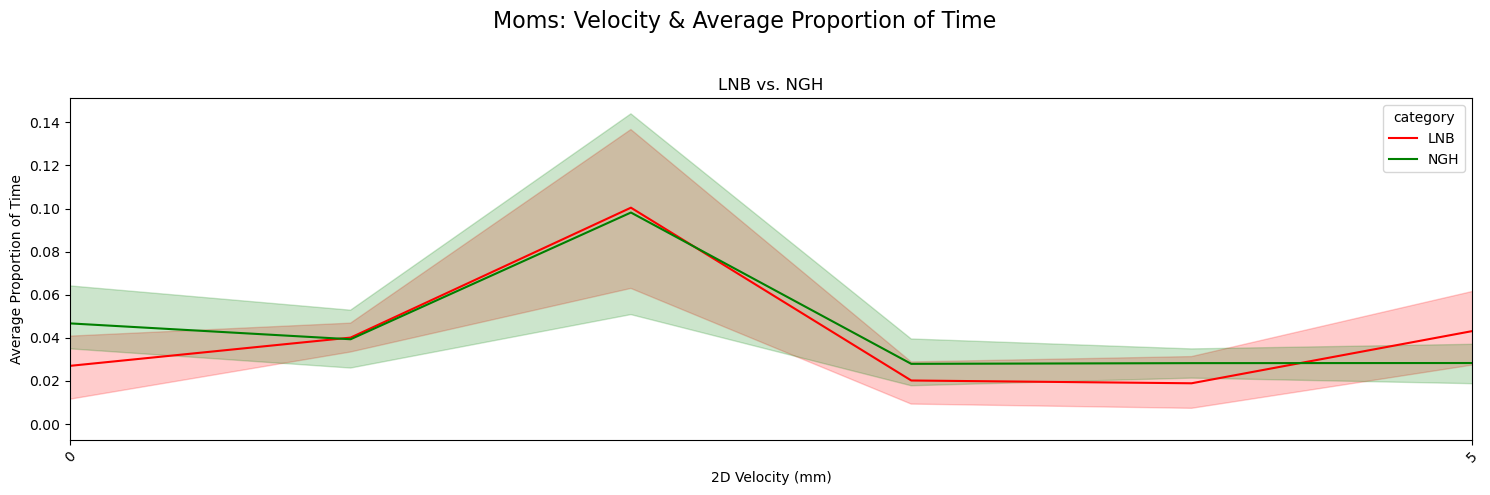

In [126]:
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Moms: Velocity & Average Proportion of Time', '2D Velocity (mm)', 'Average Proportion of Time', 'mann-whit', [0, 5], save_dir)

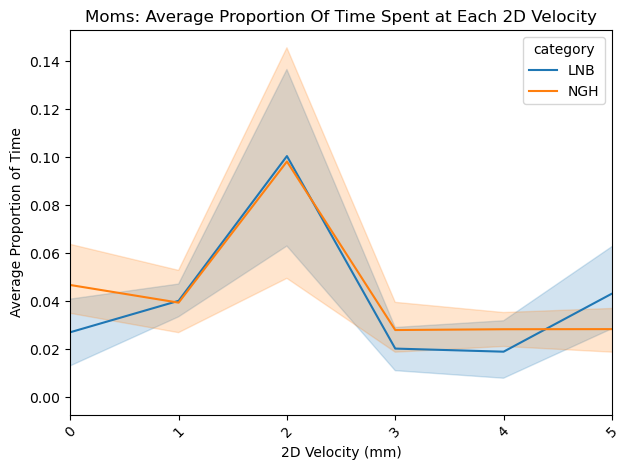

In [127]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 1))
plt.xlim(0, 5)
plt.title('Moms: Average Proportion Of Time Spent at Each 2D Velocity')
plt.xlabel('2D Velocity (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

In [53]:
f_pos_df = reformat_df(females_df, 'velocity_2d_mm')
f_pos_df = rename_groups(f_pos_df)

In [54]:
save_dir = os.path.join(root, 'Females')

Mann-Whitney U Statistic: 28.0
P-Value: 0.662004662004662
Mann-Whitney U Statistic: 18.0
P-Value: 0.4908424908424909
Mann-Whitney U Statistic: 12.0
P-Value: 0.8175206026417641


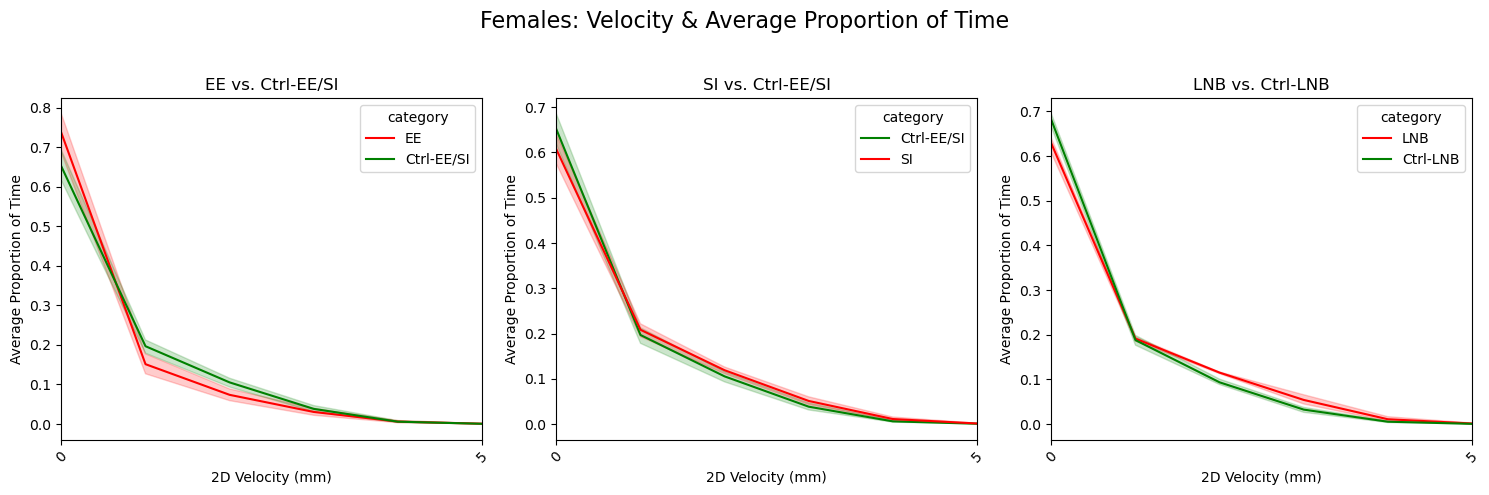

In [55]:
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Velocity & Average Proportion of Time', '2D Velocity (mm)', 'Average Proportion of Time', 'mann-whit', [0, 5], save_dir)

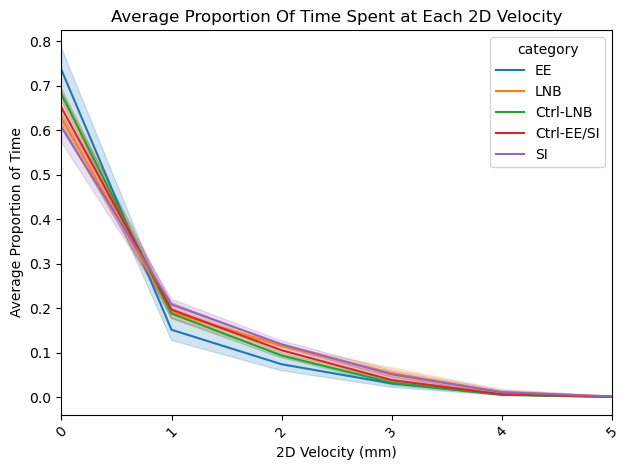

In [56]:
sns.lineplot(data=f_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(f_pos_df['Metric'].unique()), 1))
plt.xlim(0, 5)
plt.title('Average Proportion Of Time Spent at Each 2D Velocity')
plt.xlabel('2D Velocity (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

## Avg Height

In [57]:
root = '/om2/user/mabdel03/files/BTI/Moseq/10-30-24_Moms_Meeting/Figures'

### Males

In [113]:
m_pos_df = reformat_df(Moms_df, 'height_ave_mm')
m_pos_df = rename_groups(m_pos_df)

In [114]:
save_dir = root

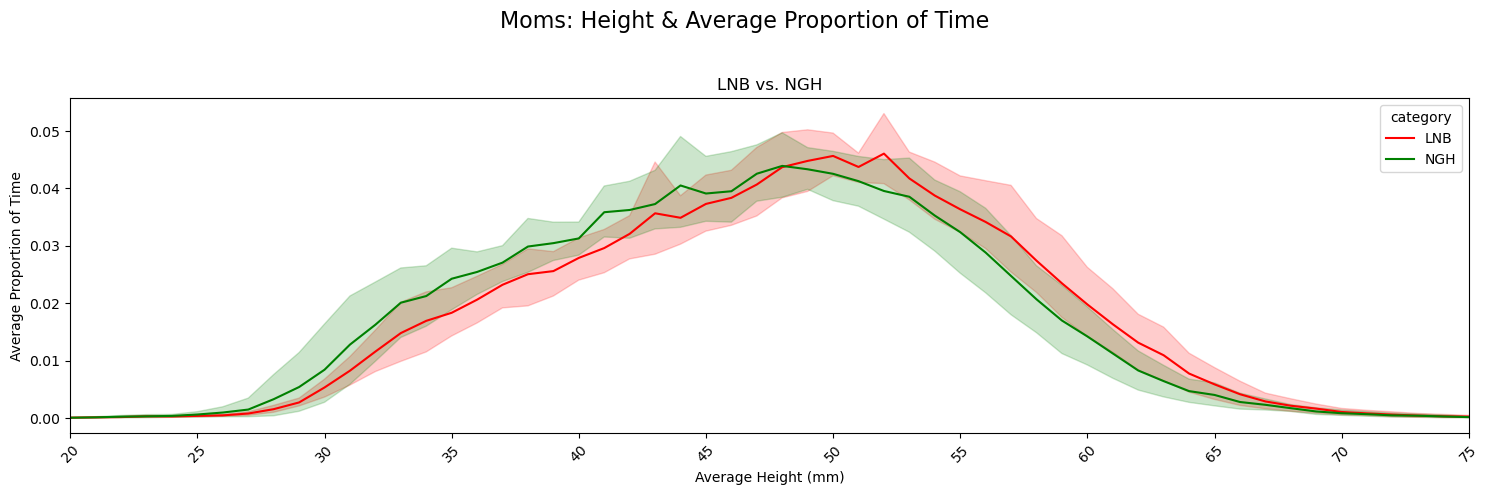

In [121]:
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Moms: Height & Average Proportion of Time', 'Average Height (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

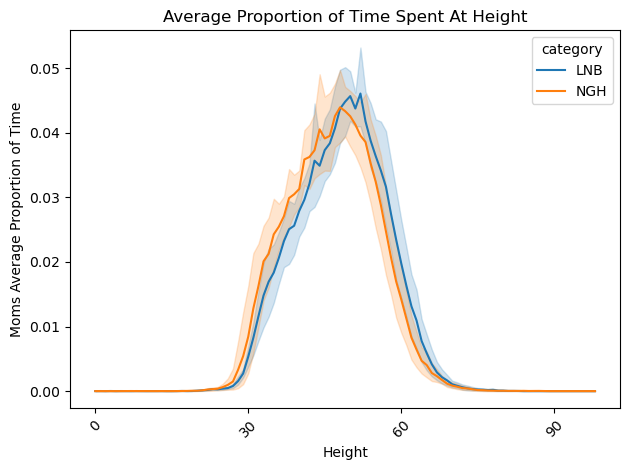

In [122]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Average Proportion of Time Spent At Height')
plt.xlabel('Height')
plt.ylabel('Moms Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

In [62]:
f_pos_df = reformat_df(females_df, 'height_ave_mm')
f_pos_df = rename_groups(f_pos_df)

In [63]:
save_dir = os.path.join(root, 'Females')

Mann-Whitney U Statistic: 25.0
P-Value: 0.9497169497169498
Mann-Whitney U Statistic: 17.5
P-Value: 0.4380742250095645
Mann-Whitney U Statistic: 14.5
P-Value: 0.4222041605136837


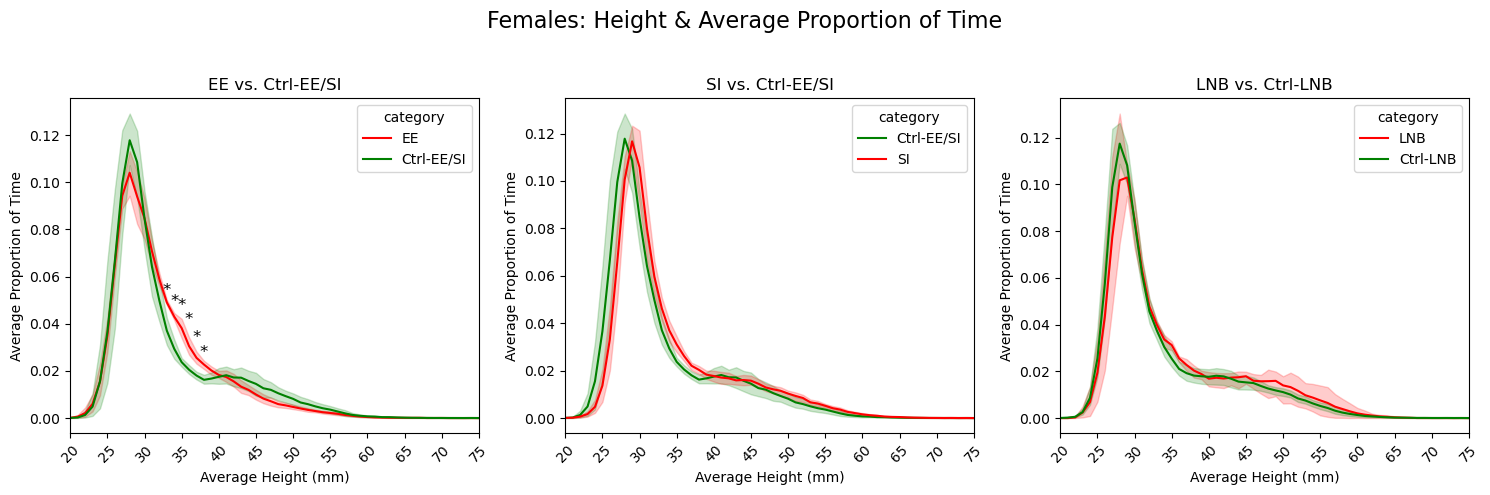

In [64]:
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Height & Average Proportion of Time', 'Average Height (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

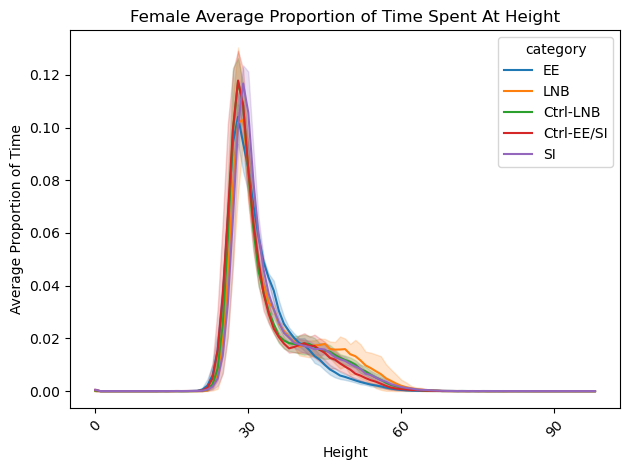

In [65]:
sns.lineplot(data=f_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(f_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Female Average Proportion of Time Spent At Height')
plt.xlabel('Height')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

## Length

In [38]:
root = '/om2/user/mabdel03/files/BTI/Moseq/10-30-24_Moms_Meeting/Figures'

### Moms

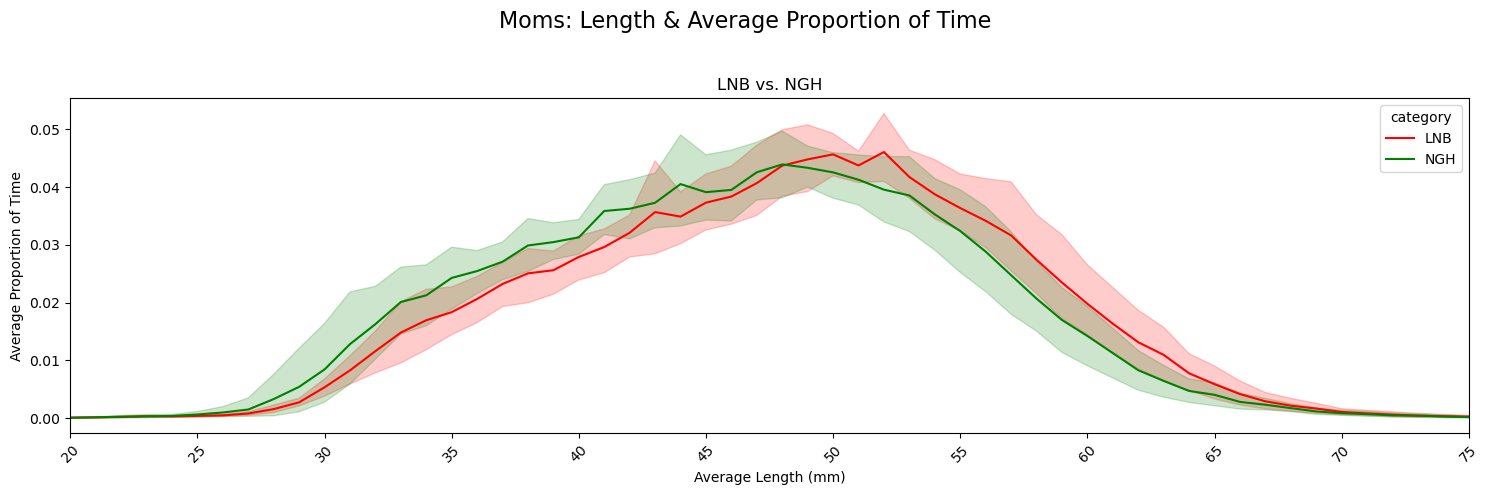

In [120]:
m_pos_df = reformat_df(Moms_df, 'length_mm')
m_pos_df = rename_groups(m_pos_df)
save_dir = root
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Moms: Length & Average Proportion of Time', 'Average Length (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

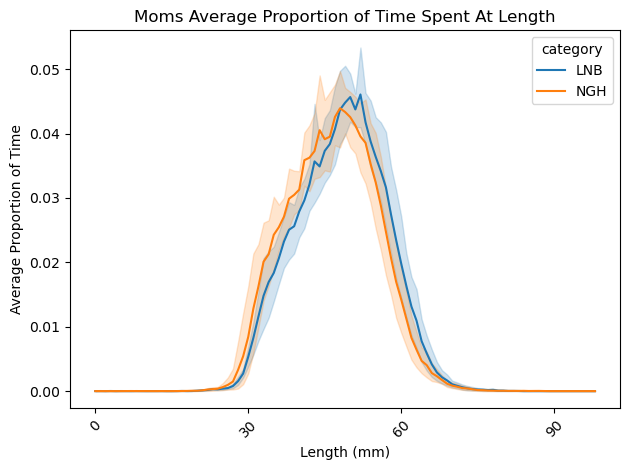

In [119]:
sns.lineplot(data=m_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(m_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Moms Average Proportion of Time Spent At Length')
plt.xlabel('Length (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

Mann-Whitney U Statistic: 33.0
P-Value: 0.2823842823842824
Mann-Whitney U Statistic: 16.0
P-Value: 0.344988344988345
Mann-Whitney U Statistic: 13.0
P-Value: 0.6475057684266377


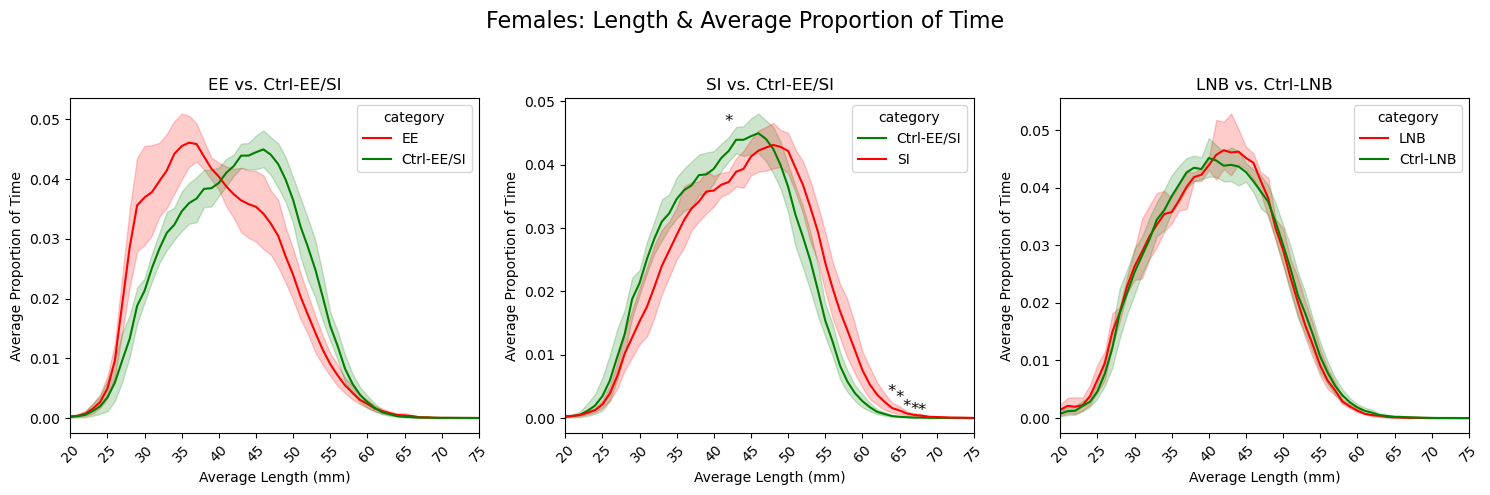

In [69]:
f_pos_df = reformat_df(females_df, 'length_mm')
f_pos_df = rename_groups(f_pos_df)
save_dir = os.path.join(root, 'Females')
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Females: Length & Average Proportion of Time', 'Average Length (mm)', 'Average Proportion of Time', 'mann-whit', [20, 75], save_dir)

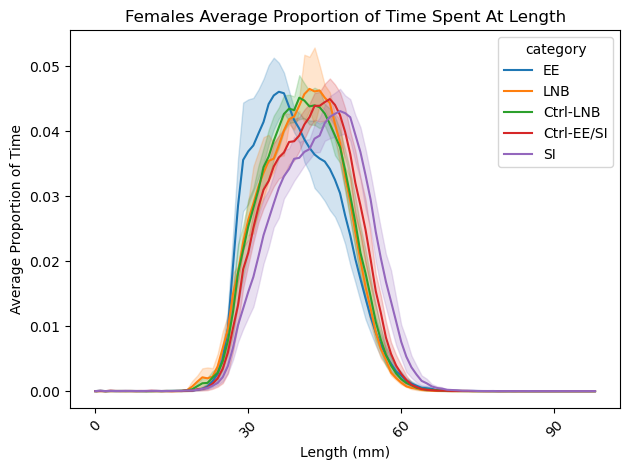

In [70]:
sns.lineplot(data=f_pos_df, x='Metric', y='avg_time', hue='category')
plt.xticks(ticks=range(0, len(f_pos_df['Metric'].unique()), 30))
# Customize the plot
plt.title('Females Average Proportion of Time Spent At Length')
plt.xlabel('Length (mm)')
plt.ylabel('Average Proportion of Time')
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()

## Moseq

### Males

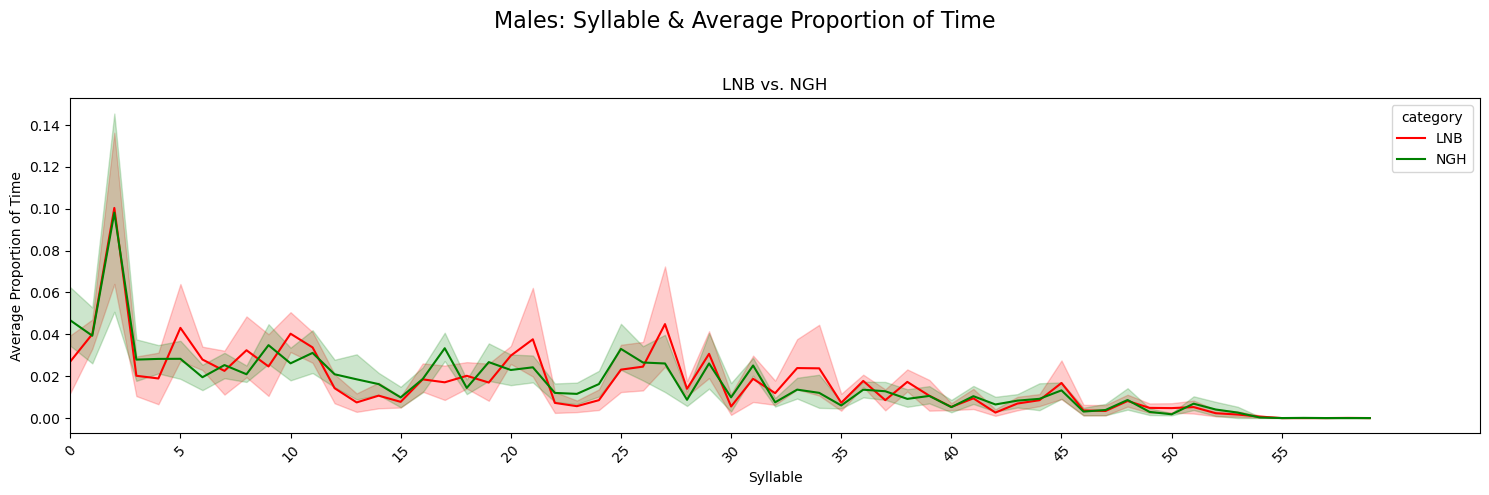

In [123]:
m_pos_df = reformat_df(Moms_df, 'MoSeq')
m_pos_df = rename_groups(m_pos_df)
pairwise_plots(m_pos_df, ('Metric', 'avg_time'), 'Males: Syllable & Average Proportion of Time', 'Syllable', 'Average Proportion of Time', 'NA', [0, 64])

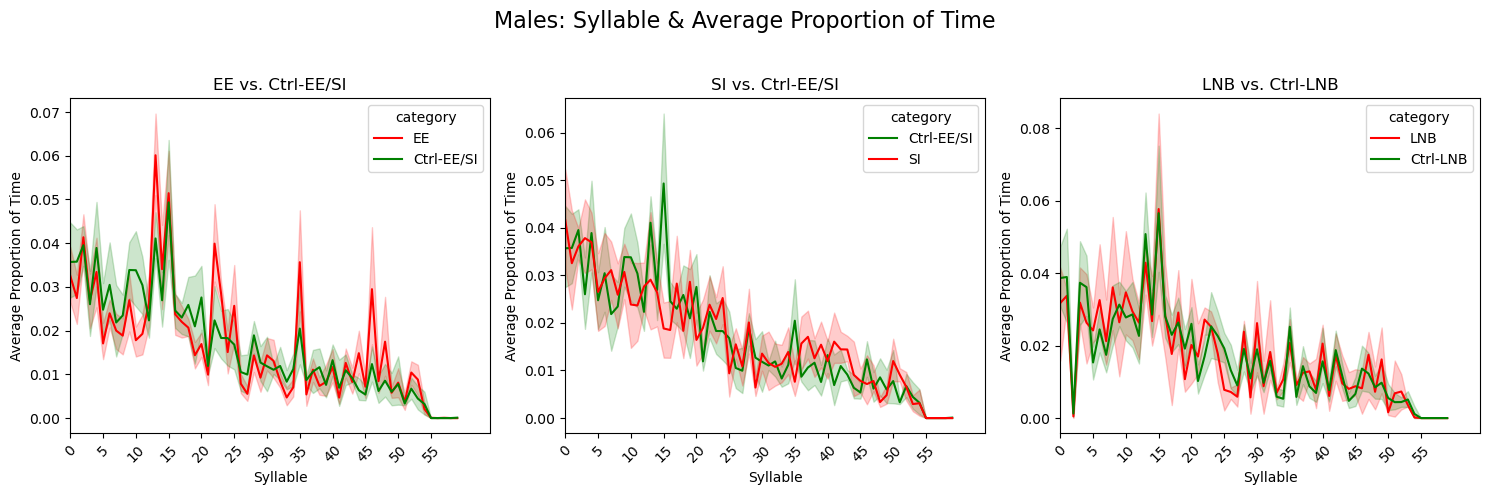

In [96]:
f_pos_df = reformat_df(females_df, 'MoSeq')
f_pos_df = rename_groups(f_pos_df)
pairwise_plots(f_pos_df, ('Metric', 'avg_time'), 'Males: Syllable & Average Proportion of Time', 'Syllable', 'Average Proportion of Time', 'NA', [0, 64])

# Transition Matrix Analysis

## Assembling The Matrices From CSVs

In [12]:
import numpy as np

In [13]:
root = '/om/scratch/Fri/mabdel03/BTI/Moseq/moseq_data/moseq_data/models/model-014-8858668'

In [14]:
from os.path import join

In [15]:
paths = {
    'LNB_Mom': join(root, 'LNB_Mom_Female_rows_transition_matrix.csv'),
    'NGH_Mom': join(root, 'NGH_Mom_Female_rows_transition_matrix.csv'),                 
}

In [16]:
matrices = {}
for name, path in paths.items():
    matrices[name] = np.genfromtxt(path, delimiter=',', skip_header=1)

males = {key.split('_')[0]: value for key, value in matrices.items() if key.endswith('Male')}
females = {key.split('_')[0]: value for key, value in matrices.items() if key.endswith('Female')}

FileNotFoundError: /om/scratch/Fri/mabdel03/BTI/Moseq/moseq_data/moseq_data/models/model-014-8858668/LNB_Mom_Female_rows_transition_matrix.csv not found.

In [7]:
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

## Visualizations

### Males

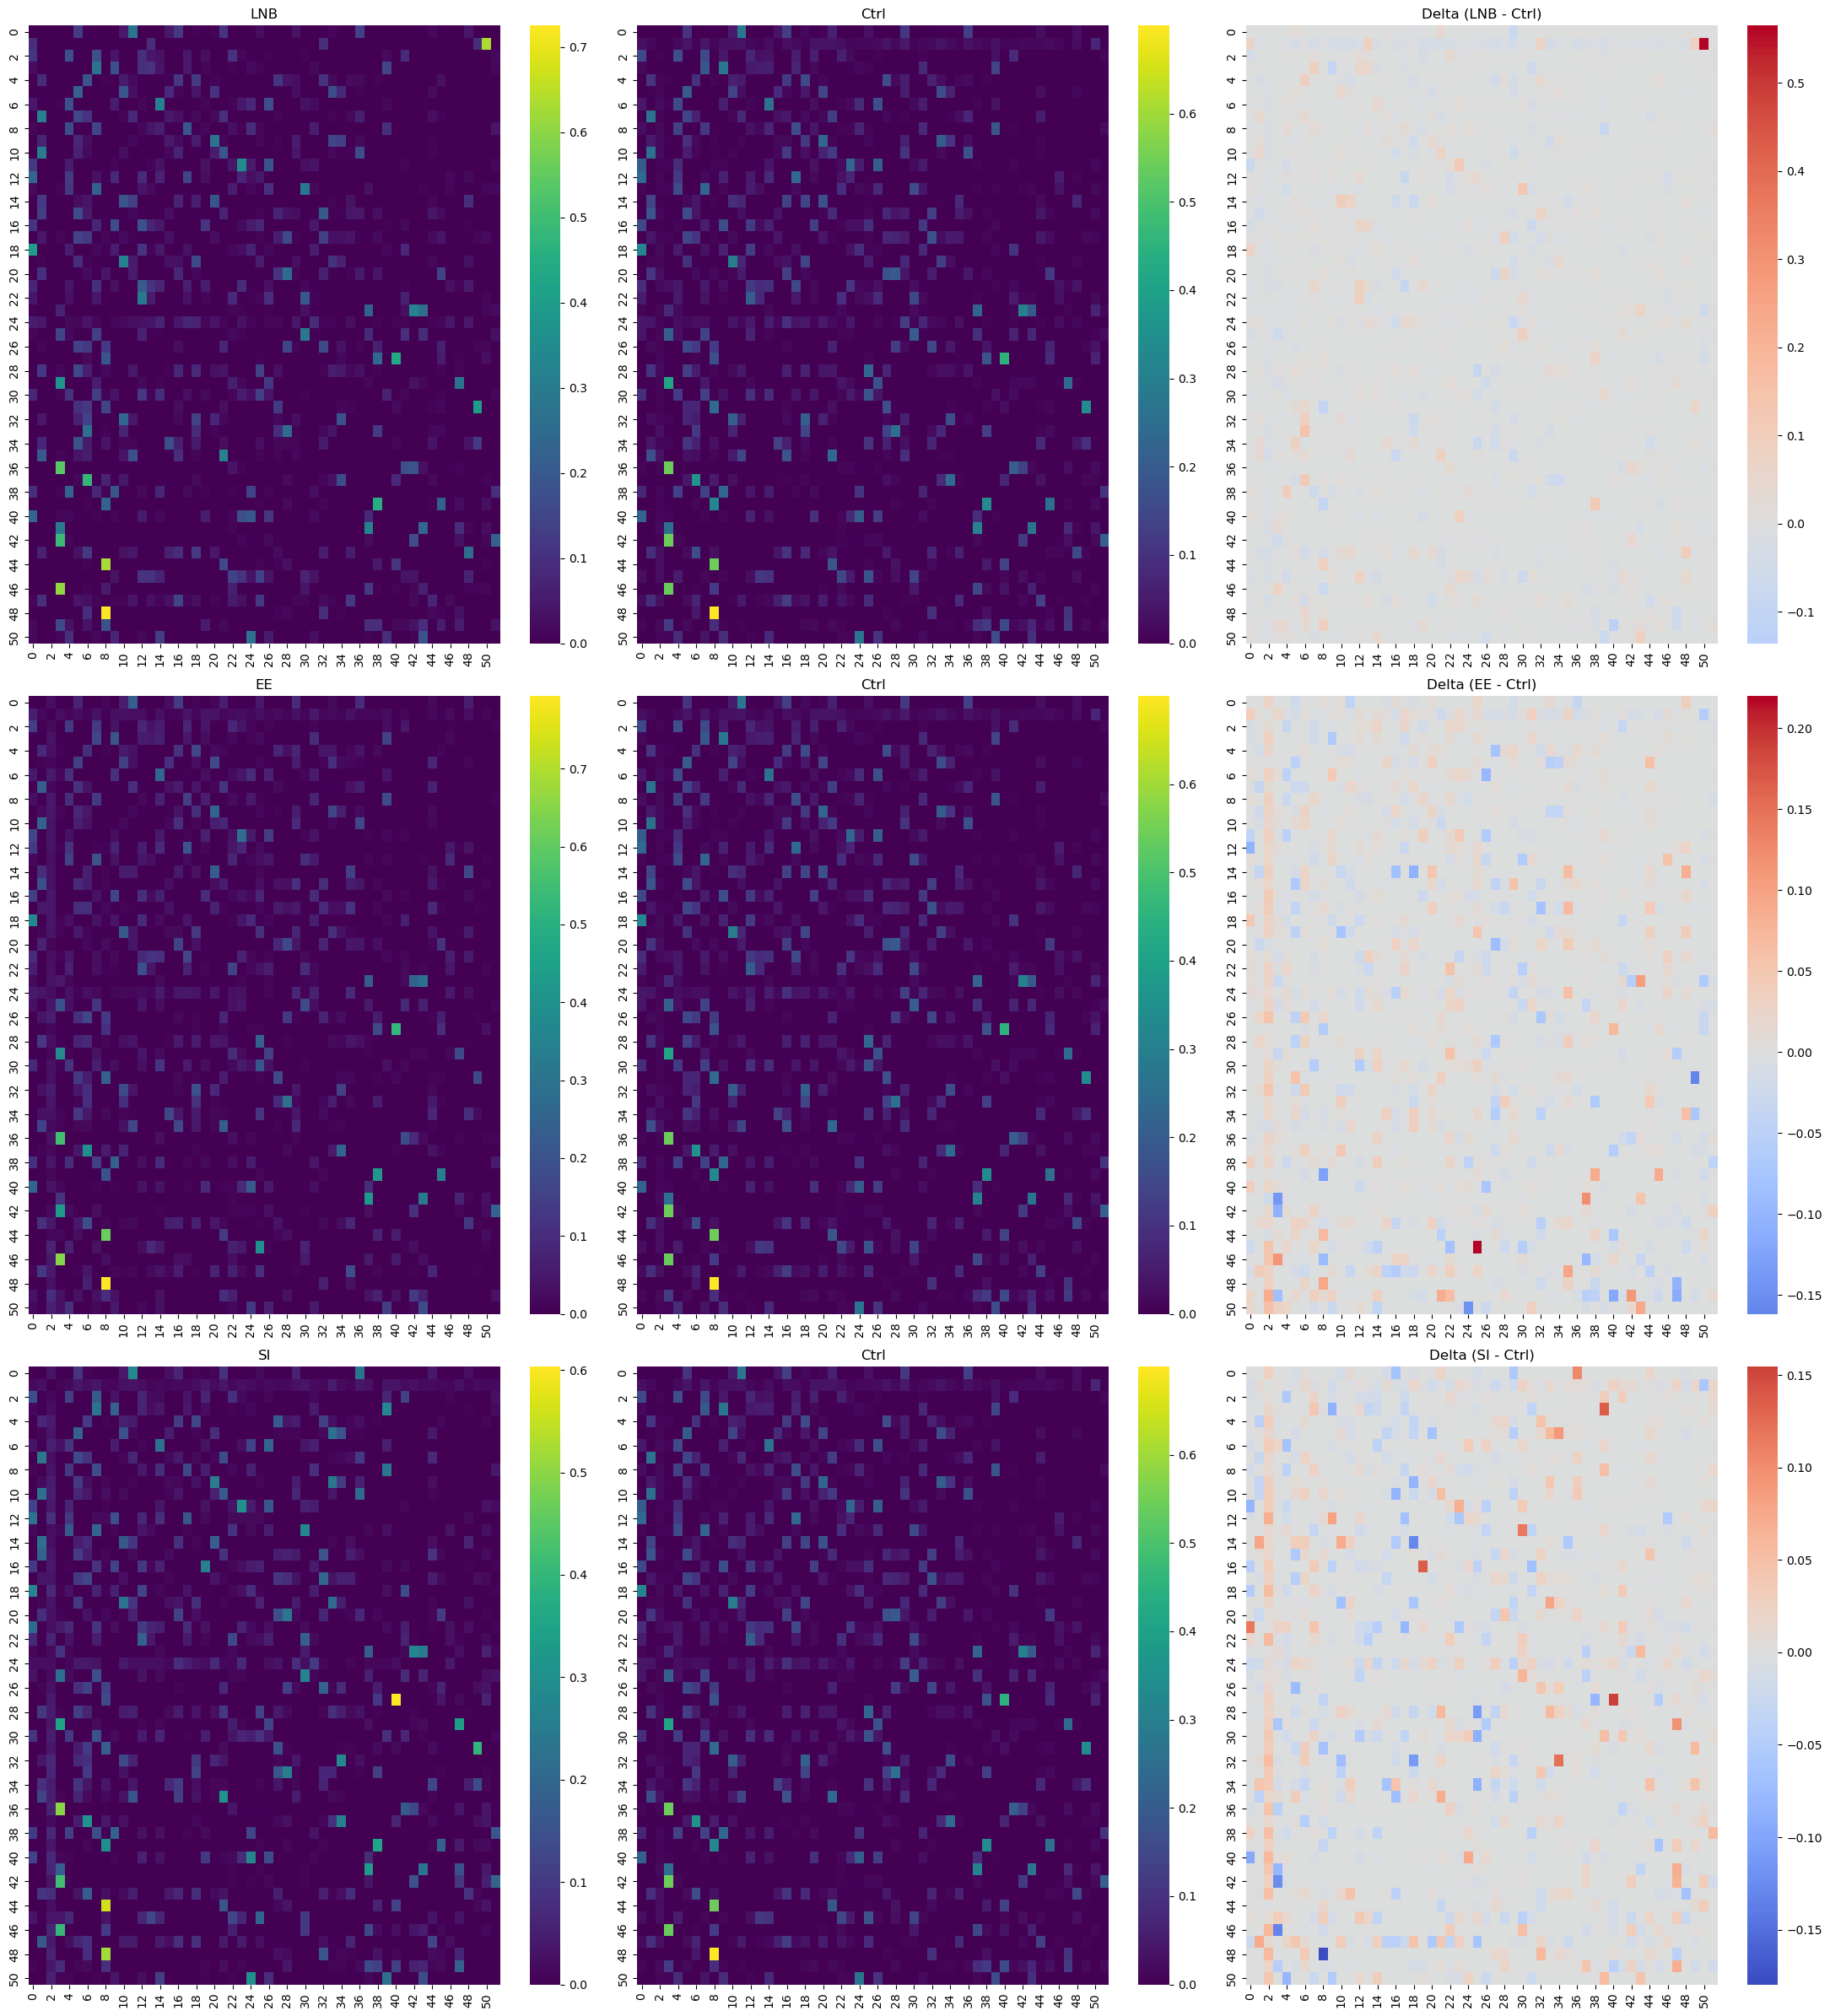

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your specific comparisons list
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

# Split the comparisons into two groups
comparisons_group1 = comparisons[:3]  # First 3 comparisons
comparisons_group2 = comparisons[3:]   # Last 2 comparisons

def plot_comparisons(comparisons, panel_name):
    n_comparisons = len(comparisons)

    # Create a figure with 3 columns and n_comparisons rows
    fig, axes = plt.subplots(n_comparisons, 3, figsize=(22, 8 * n_comparisons))

    # If there's only one comparison, adjust axes for single row case
    if n_comparisons == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, (mat1, mat2) in enumerate(comparisons):
        matrix1 = males[mat1]
        matrix2 = males[mat2]

        # Compute the difference (delta) matrix
        delta_matrix = matrix1 - matrix2

        # Plot the matrices side by side and the delta matrix
        sns.heatmap(matrix1, ax=axes[i, 0], cmap="viridis")
        axes[i, 0].set_title(mat1)

        sns.heatmap(matrix2, ax=axes[i, 1], cmap="viridis")
        axes[i, 1].set_title(mat2)

        sns.heatmap(delta_matrix, ax=axes[i, 2], cmap="coolwarm", center=0)
        axes[i, 2].set_title(f'Delta ({mat1} - {mat2})')

    # Adjust layout to avoid overlapping titles and labels
    plt.tight_layout()

    # Save the figure as a PNG if needed
    plt.savefig(f"{panel_name}.png")

    plt.show()

# Plot the first group of comparisons
plot_comparisons(comparisons_group1, "comparison_panel_1")


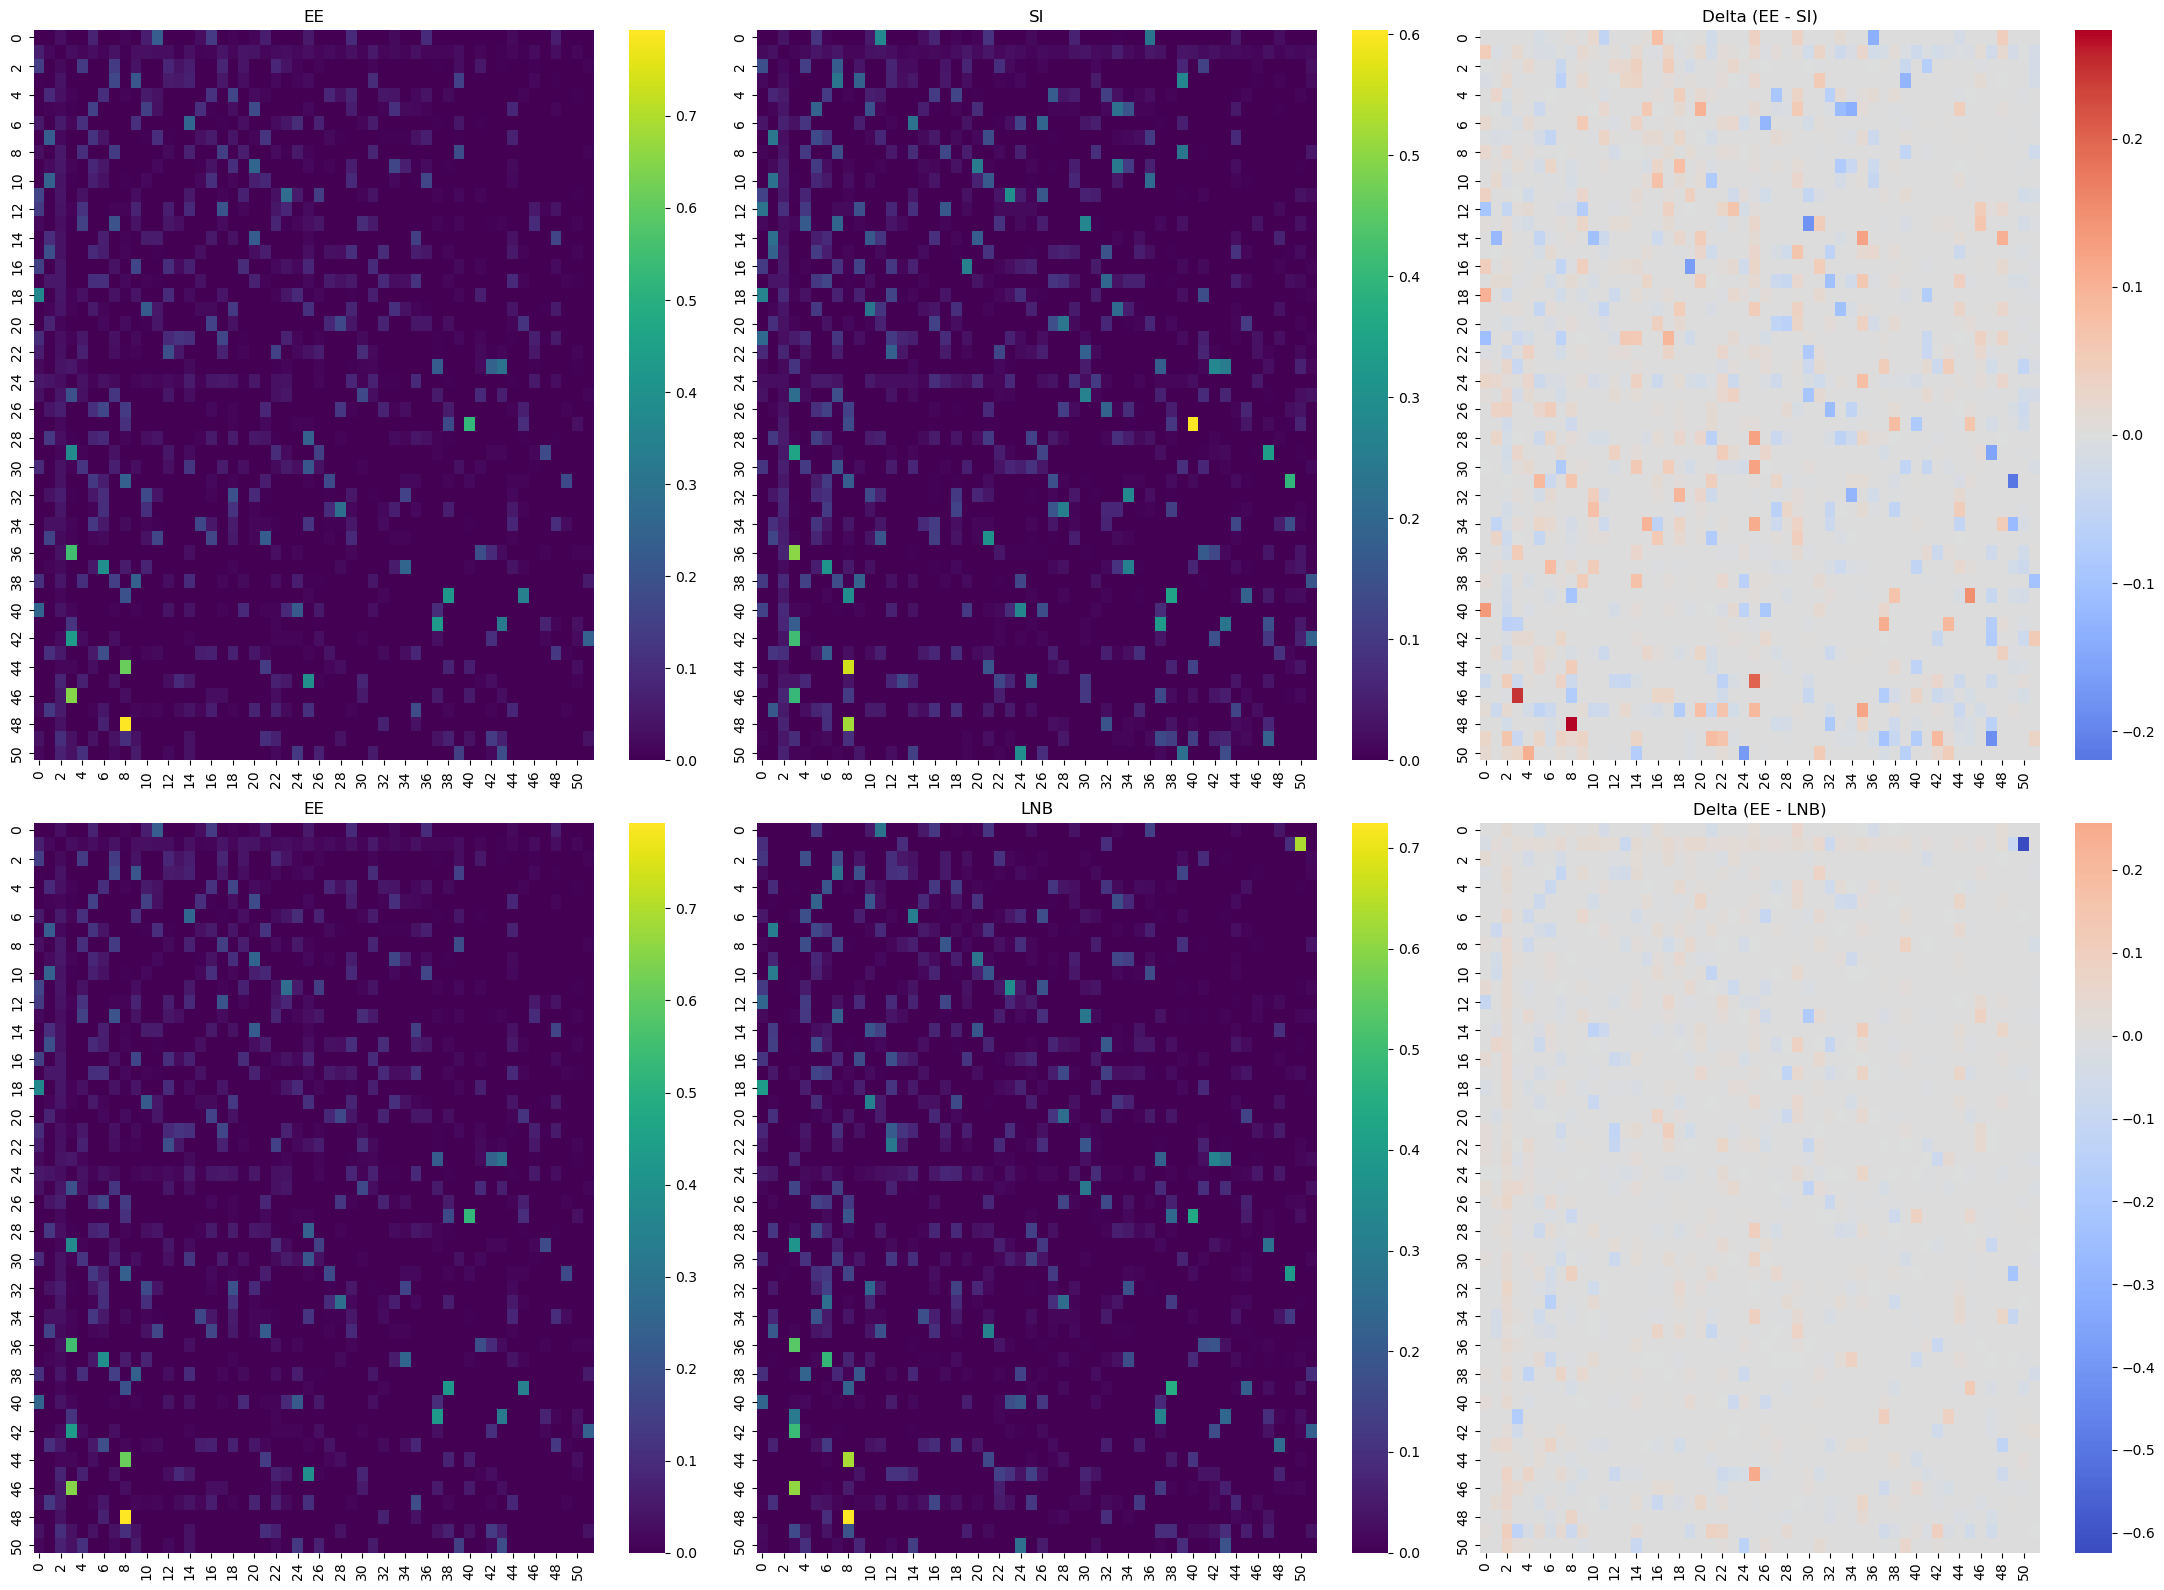

In [11]:
# Plot the second group of comparisons
plot_comparisons(comparisons_group2, "comparison_panel_2")

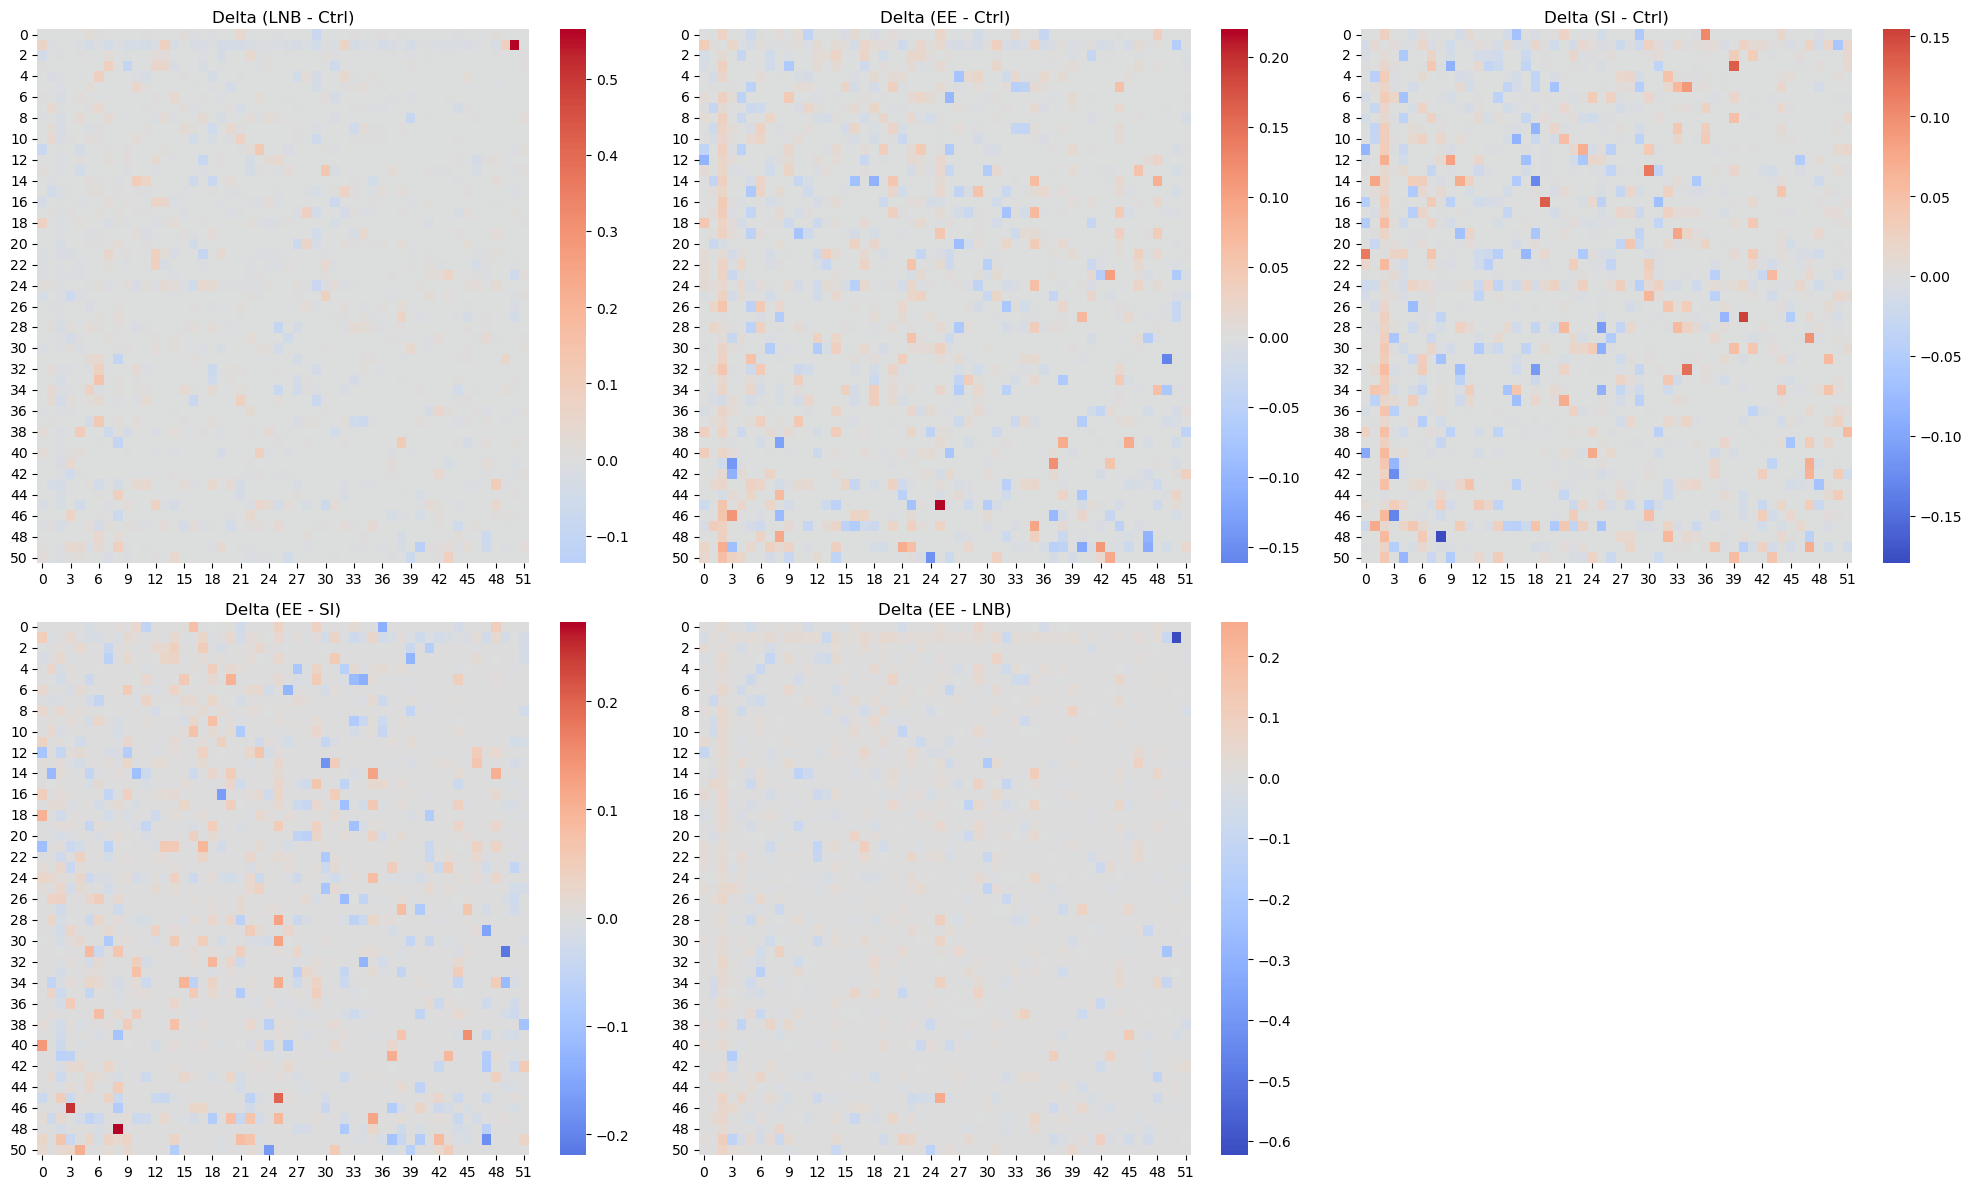

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your specific comparisons list
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

# Determine the number of comparisons
n_comparisons = len(comparisons)

# Calculate grid dimensions (e.g., 2 rows and 3 columns for 5 comparisons)
rows = 2
cols = 3  # One extra column for padding or use 2x3 grid depending on layout preference

# Create a figure with a grid to fit all delta plots
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (mat1, mat2) in enumerate(comparisons):
    matrix1 = males[mat1]
    matrix2 = males[mat2]

    # Compute the difference (delta) matrix
    delta_matrix = matrix1 - matrix2

    # Plot the delta matrix
    sns.heatmap(delta_matrix, ax=axes[i], cmap="coolwarm", center=0)
    axes[i].set_title(f'Delta ({mat1} - {mat2})')

# Hide any unused subplots (if cols*rows > n_comparisons)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make sure plots fit nicely
plt.tight_layout()

# Save the figure as a PNG suitable for Google Slides
plt.savefig("delta_comparison_panel_for_slide.png", dpi=300)

plt.show()


### Females

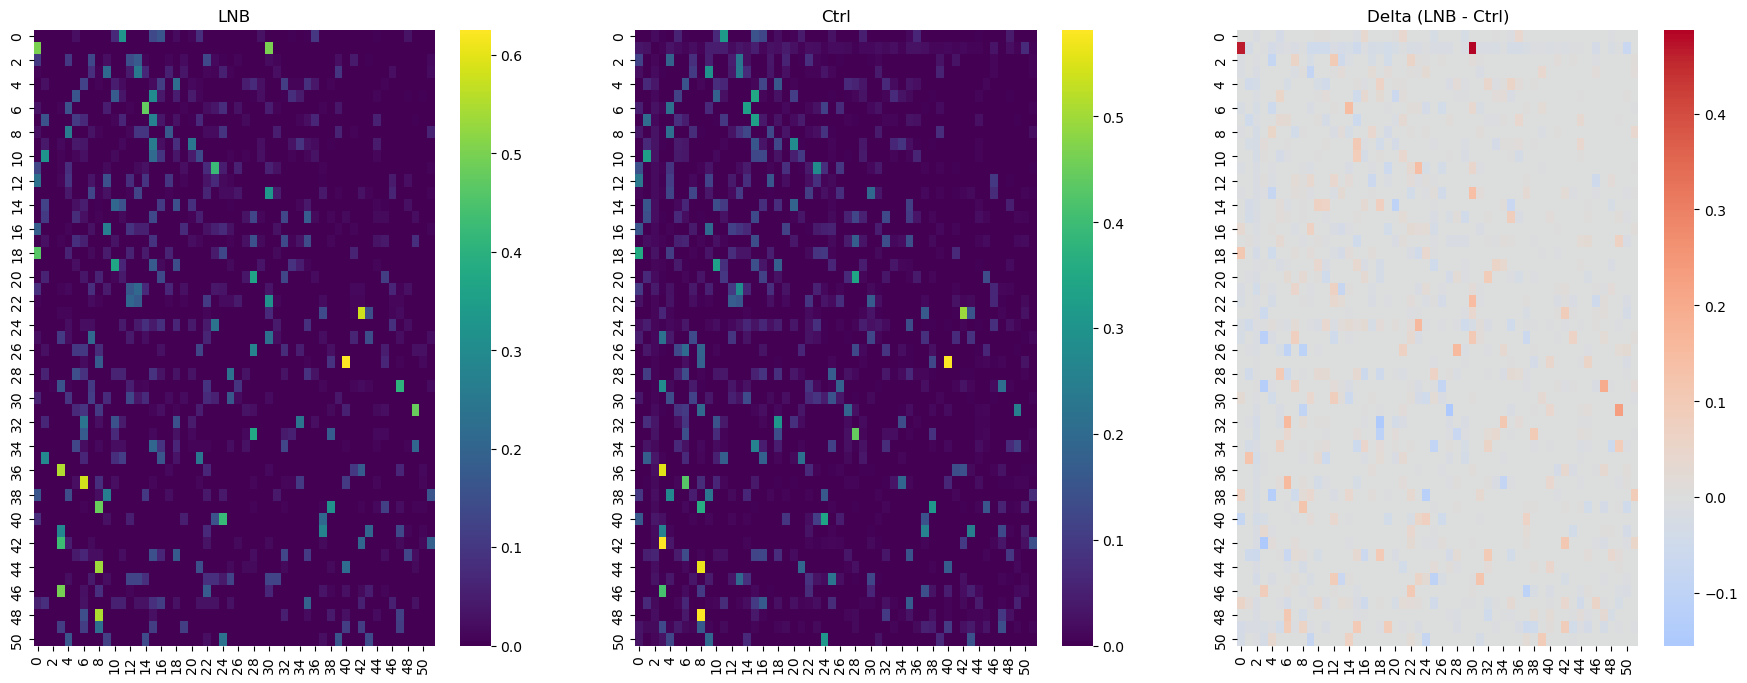

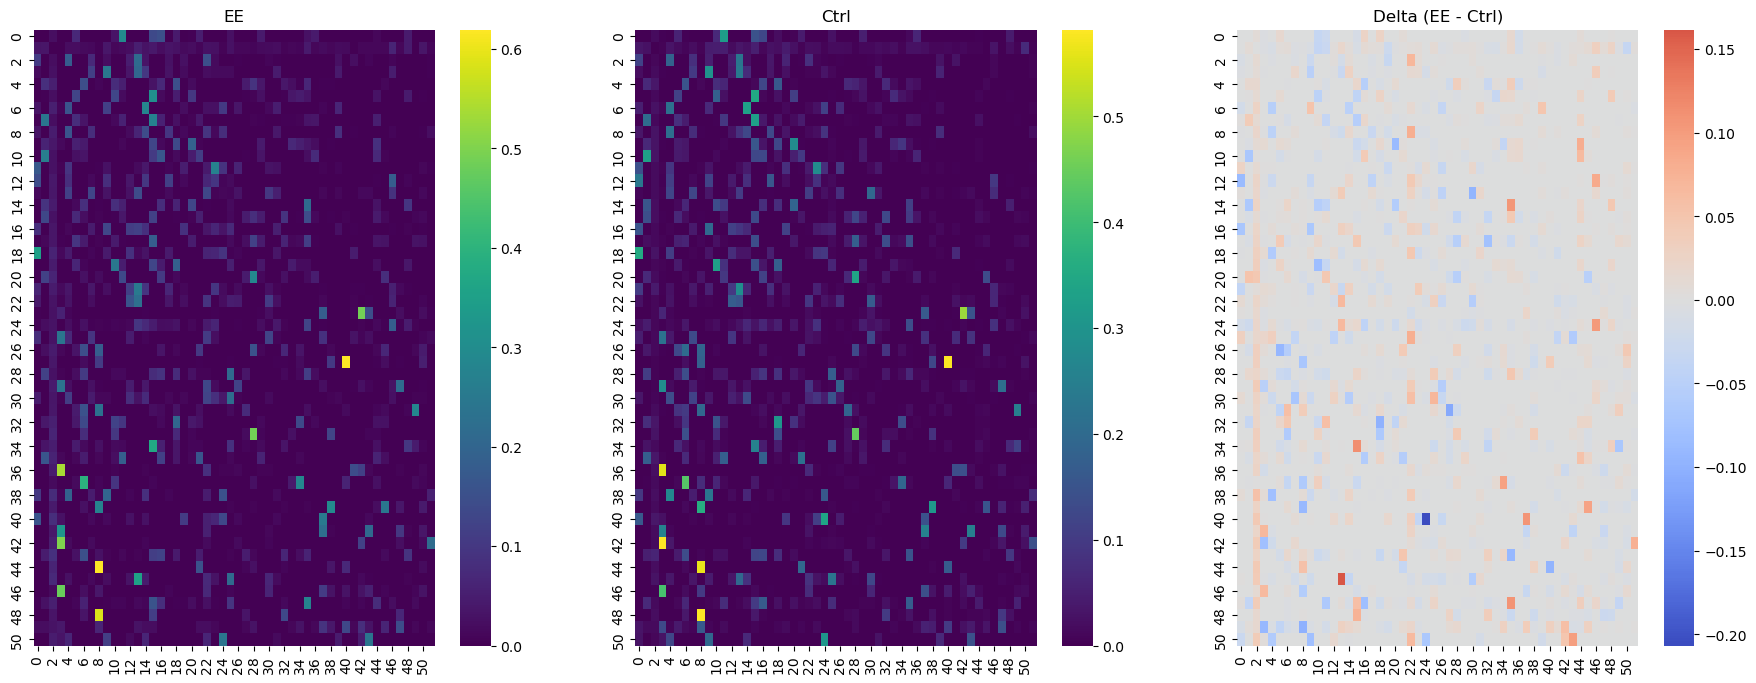

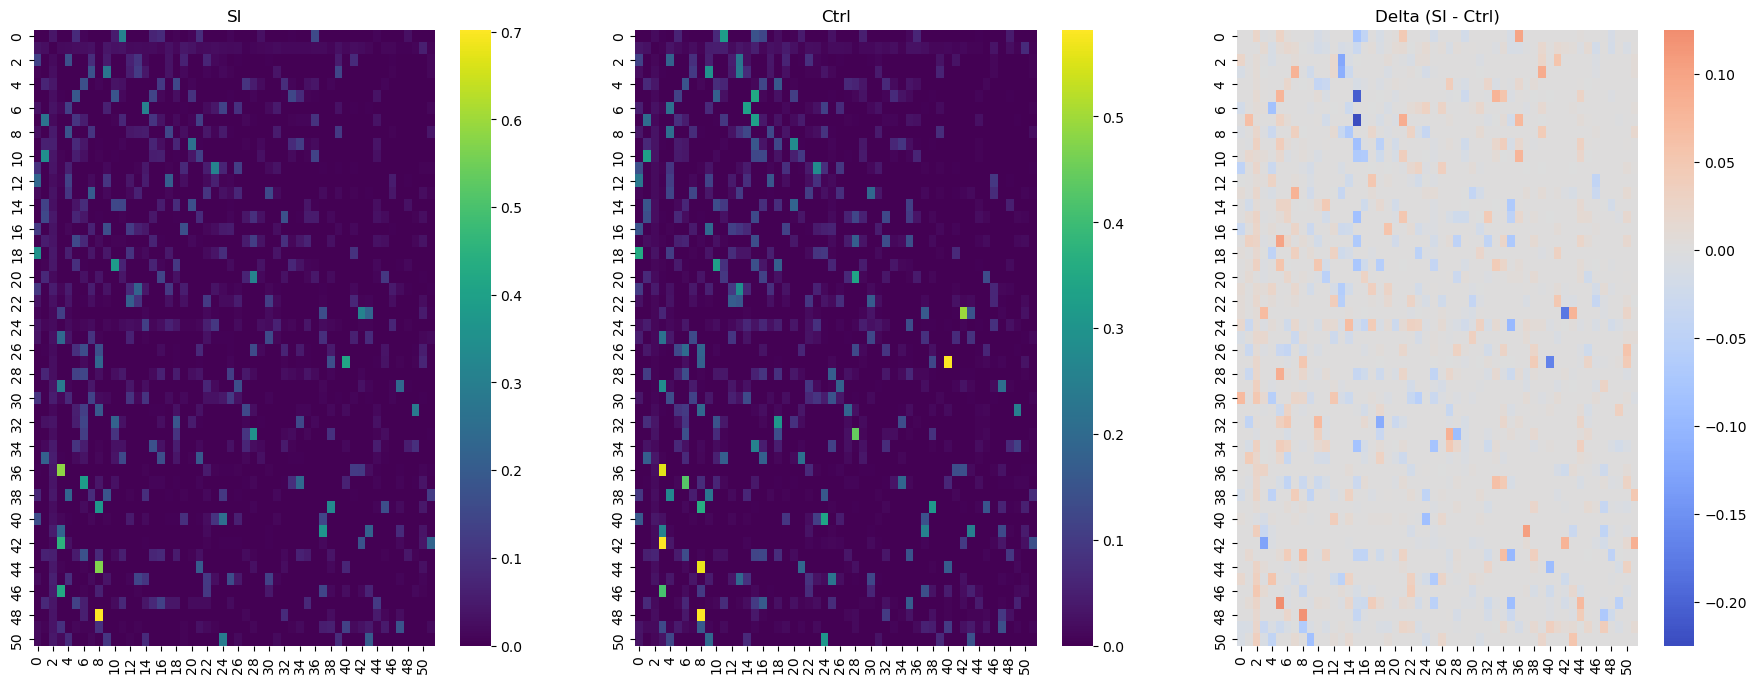

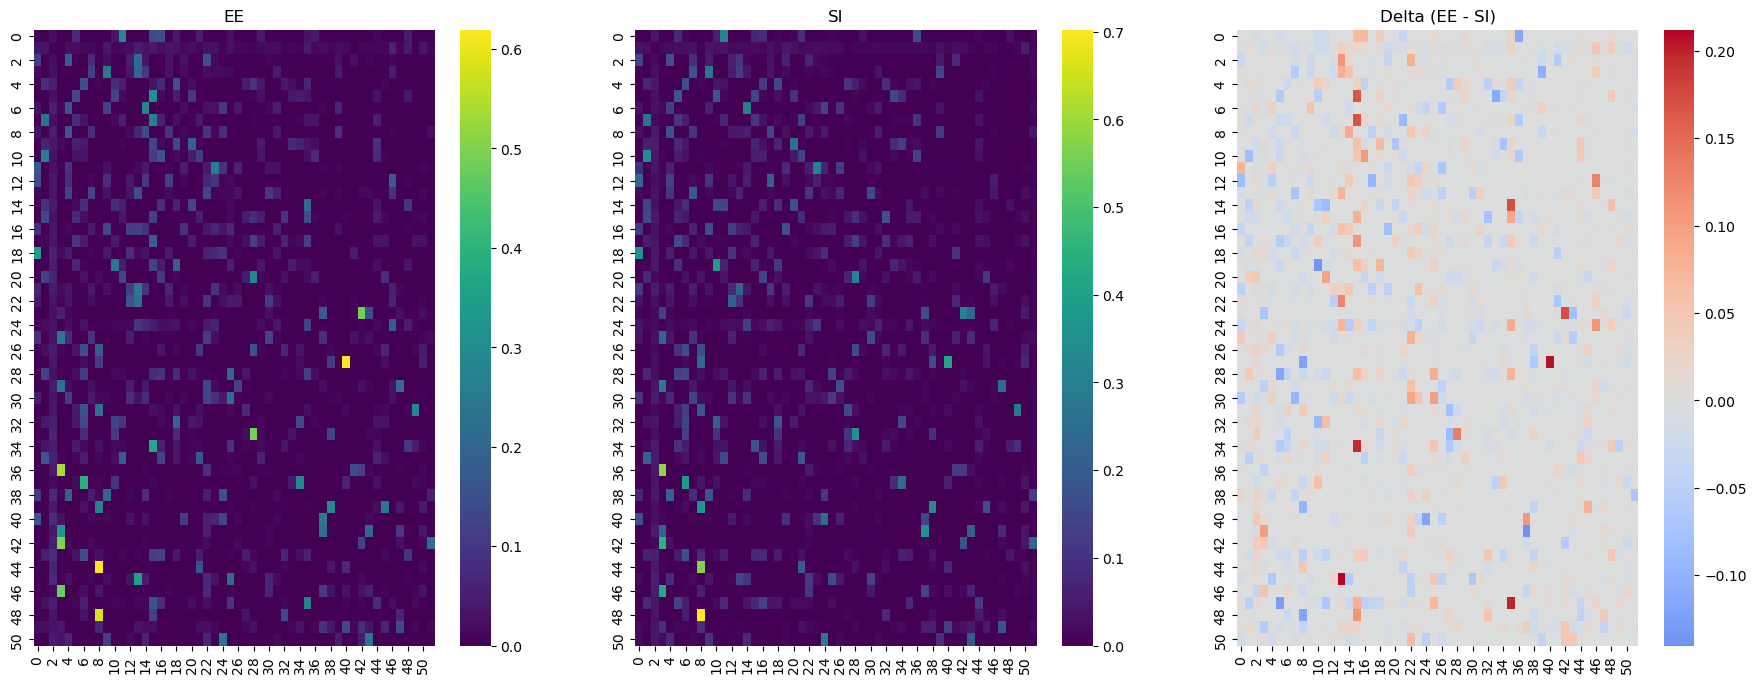

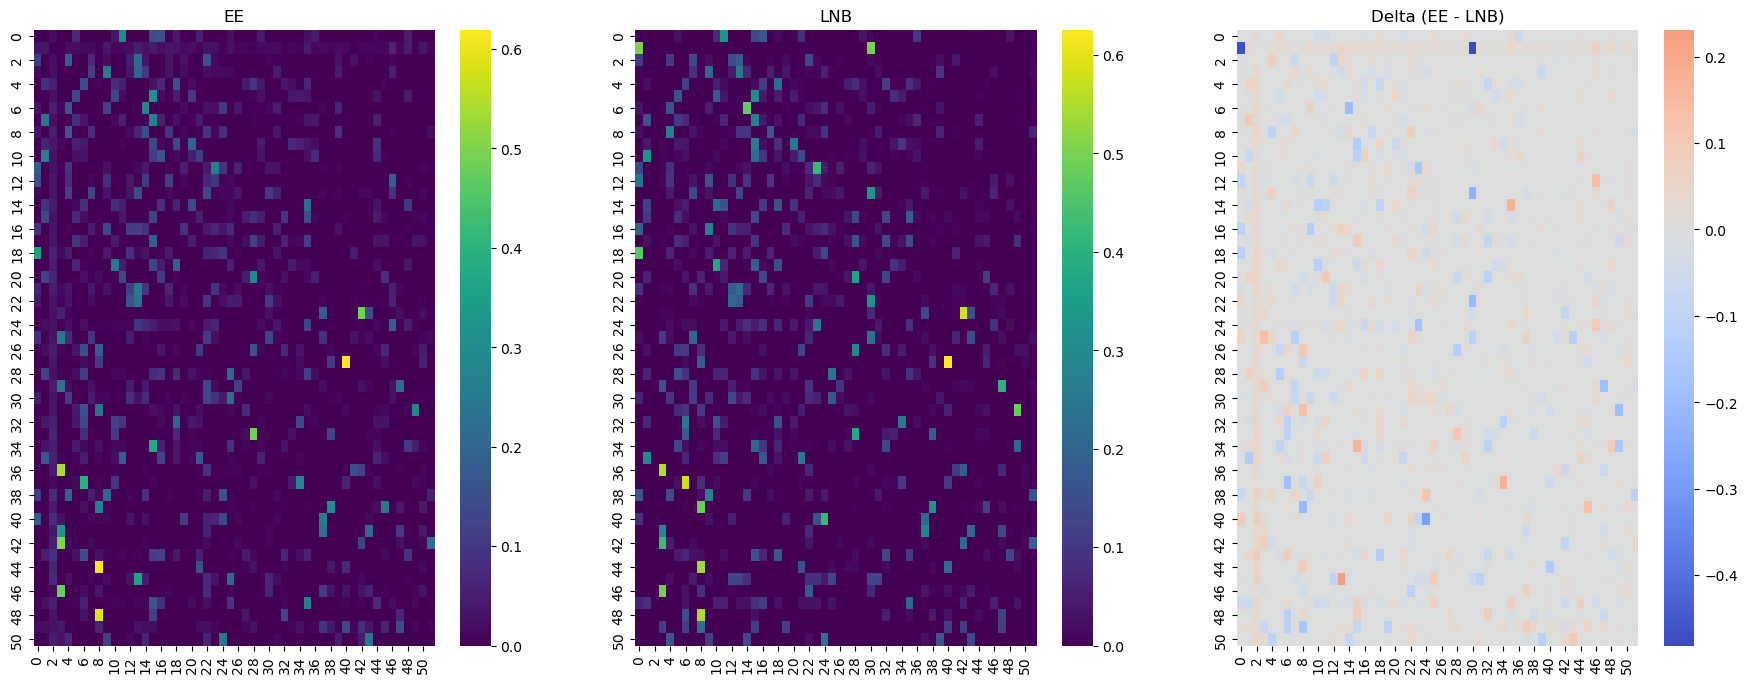

In [130]:
for mat1, mat2 in comparisons:

    matrix1 = females[mat1]
    matrix2 = females[mat2]

    # Compute the difference (delta) matrix
    delta_matrix = matrix1 - matrix2
    
    # Plot the matrices side by side and the delta matrix
    fig, axes = plt.subplots(1, 3, figsize=(22, 8))
    
    sns.heatmap(matrix1, ax=axes[0], cmap="viridis")
    axes[0].set_title(mat1)
    
    sns.heatmap(matrix2, ax=axes[1], cmap="viridis")
    axes[1].set_title(mat2)
    
    sns.heatmap(delta_matrix, ax=axes[2], cmap="coolwarm", center=0)
    axes[2].set_title(f'Delta ({mat1} - {mat2})')
    
    plt.show()

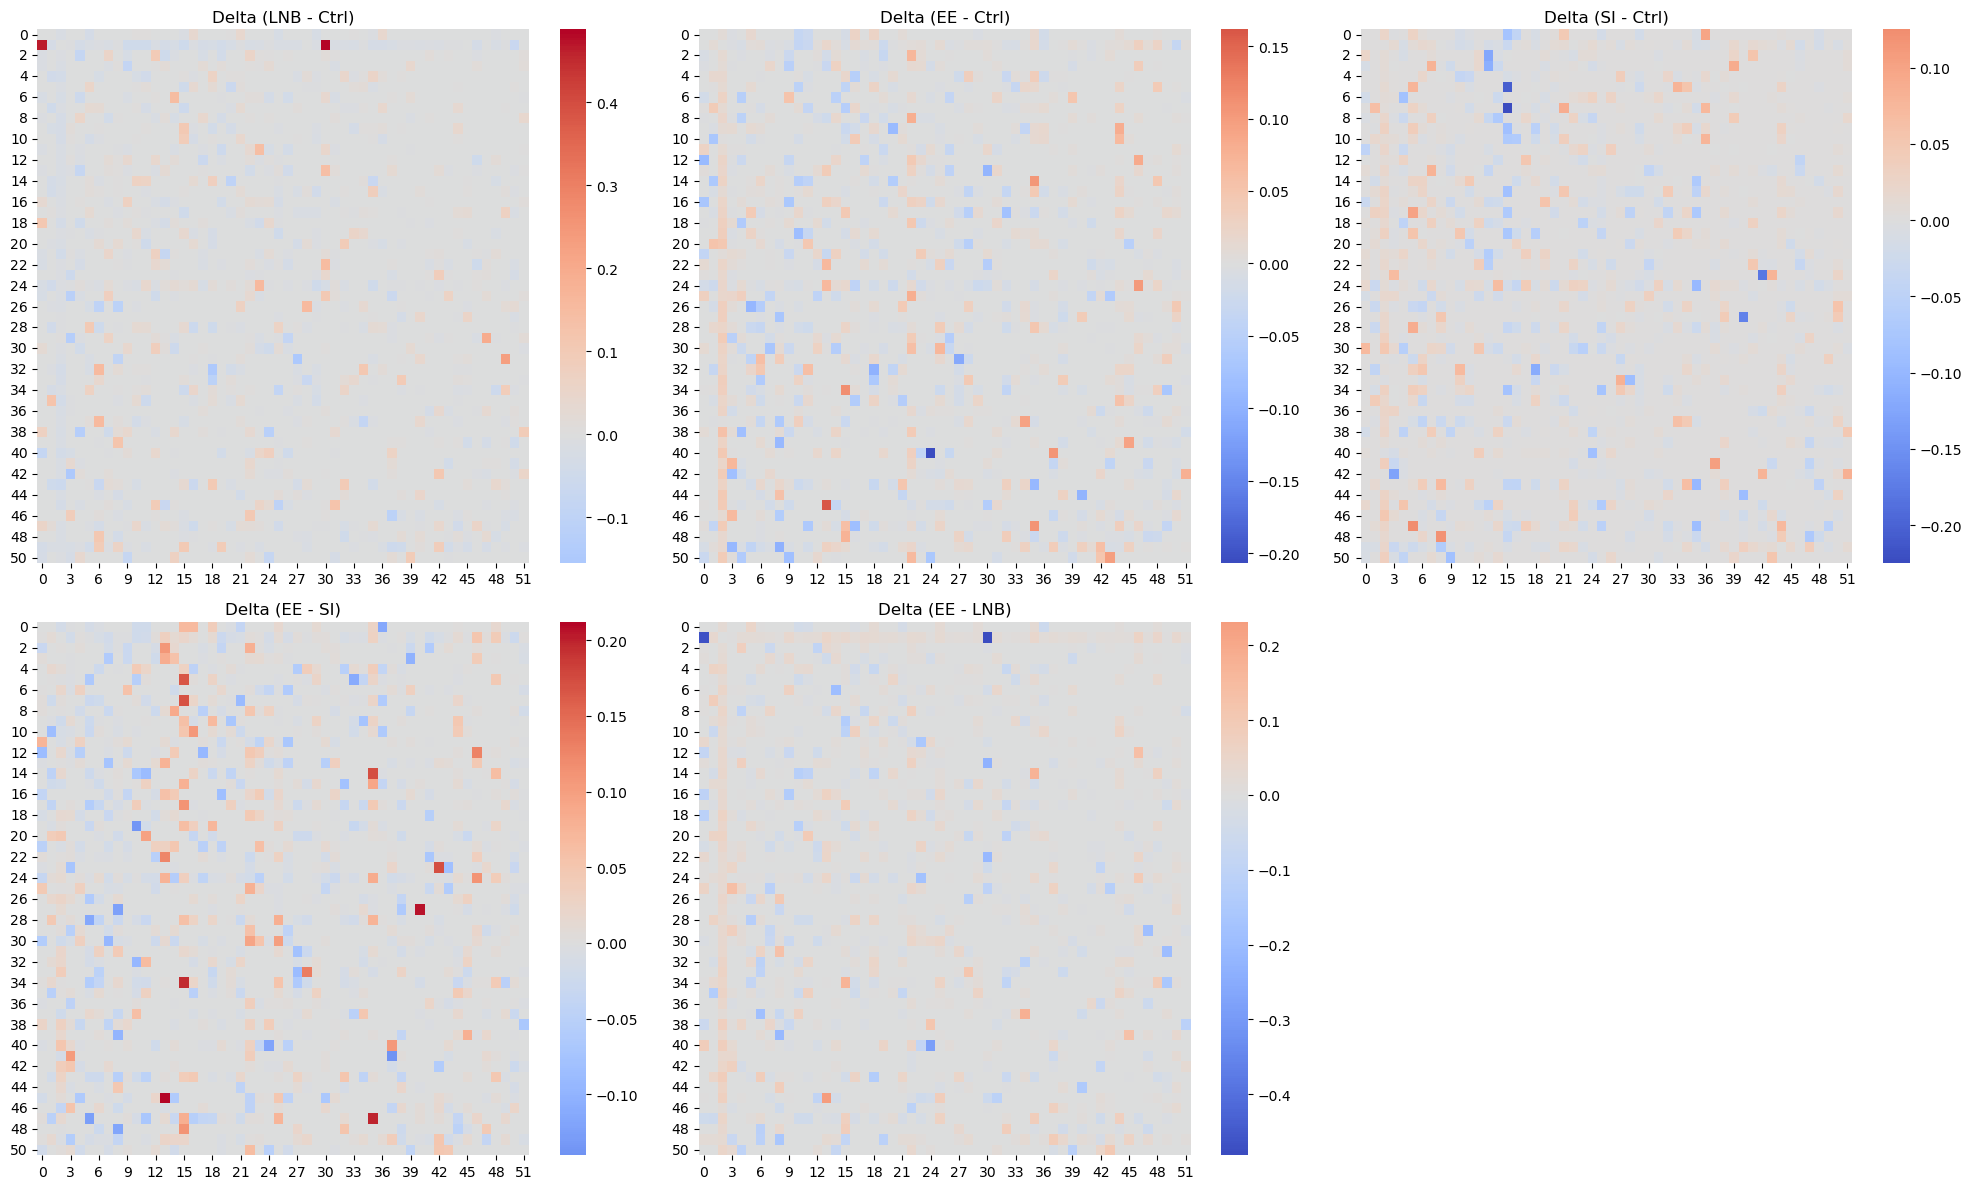

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your specific comparisons list
comparisons = [('LNB', 'Ctrl'), ('EE', 'Ctrl'), ('SI', 'Ctrl'), ('EE', 'SI'), ('EE', 'LNB')]

# Determine the number of comparisons
n_comparisons = len(comparisons)

# Calculate grid dimensions (e.g., 2 rows and 3 columns for 5 comparisons)
rows = 2
cols = 3  # One extra column for padding or use 2x3 grid depending on layout preference

# Create a figure with a grid to fit all delta plots
fig, axes = plt.subplots(rows, cols, figsize=(20, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (mat1, mat2) in enumerate(comparisons):
    matrix1 = females[mat1]
    matrix2 = females[mat2]

    # Compute the difference (delta) matrix
    delta_matrix = matrix1 - matrix2

    # Plot the delta matrix
    sns.heatmap(delta_matrix, ax=axes[i], cmap="coolwarm", center=0)
    axes[i].set_title(f'Delta ({mat1} - {mat2})')

# Hide any unused subplots (if cols*rows > n_comparisons)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make sure plots fit nicely
plt.tight_layout()

# Save the figure as a PNG suitable for Google Slides
plt.savefig("delta_comparison_panel_for_slide.png", dpi=300)

plt.show()


## Statistical Significance Testing

### Mantel Test Approach

In [141]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.stats import pearsonr
from sklearn.utils import resample

def mantel_test(matrix1, matrix2, num_permutations=1000):
    """
    Perform a Mantel test to assess the correlation between two distance matrices.

    Parameters:
    - matrix1: First distance matrix
    - matrix2: Second distance matrix
    - num_permutations: Number of permutations for the test

    Returns:
    - observed_corr: The observed correlation between the two matrices
    - p_value: The p-value for the test
    """
    # Flatten the upper triangles of both matrices
    idx = np.triu_indices_from(matrix1, k=1)
    matrix1_flat = matrix1[idx]
    matrix2_flat = matrix2[idx]

    # Calculate the observed Pearson correlation
    observed_corr, _ = pearsonr(matrix1_flat, matrix2_flat)

    # Permutation test
    permuted_corrs = []
    for _ in range(num_permutations):
        matrix2_permuted = resample(matrix2_flat)
        permuted_corr, _ = pearsonr(matrix1_flat, matrix2_permuted)
        permuted_corrs.append(permuted_corr)

    # Calculate p-value
    permuted_corrs = np.array(permuted_corrs)
    p_value = np.mean(permuted_corrs >= observed_corr)

    return observed_corr, p_value

In [142]:
for mat1, mat2 in comparisons:

    A = females[mat1]
    B = females[mat2]
    distance_matrix_A = distance_matrix(A, A)
    distance_matrix_B = distance_matrix(B, B)
    # Perform Mantel test
    observed_corr, p_value = mantel_test(distance_matrix_A, distance_matrix_B)
    
    print(f"Observed correlation: {observed_corr}")
    print(f"P-value: {p_value}")

Observed correlation: 0.7549170272144199
P-value: 0.0
Observed correlation: 0.9526050615624096
P-value: 0.0
Observed correlation: 0.9340639719276733
P-value: 0.0
Observed correlation: 0.8989712654072466
P-value: 0.0
Observed correlation: 0.7236380618433387
P-value: 0.0


### Frobenius Norm + Permutations Test Approach

In [138]:
# Calculate Frobenius norm between two matrices
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, 'fro')

# Permutation test to assess significance
def permutation_test(A, B, num_permutations=100000):
    observed_norm = frobenius_norm(A, B)
    permuted_norms = []

    for _ in range(num_permutations):
        # Permute matrix A
        permuted_A = np.random.permutation(A.flatten()).reshape(A.shape)
        permuted_norm = frobenius_norm(permuted_A, B)
        permuted_norms.append(permuted_norm)

    # Calculate p-value
    permuted_norms = np.array(permuted_norms)
    p_value = np.mean(permuted_norms >= observed_norm)

    return observed_norm, p_value

"""
# Example matrices
A = np.array([[1, 2], [3, 4]])
B = np.array([[4, 3], [2, 1]])

observed_norm, p_value = permutation_test(A, B)
print(f"Observed Frobenius norm: {observed_norm}")
print(f"p-value: {p_value}")
"""

'\n# Example matrices\nA = np.array([[1, 2], [3, 4]])\nB = np.array([[4, 3], [2, 1]])\n\nobserved_norm, p_value = permutation_test(A, B)\nprint(f"Observed Frobenius norm: {observed_norm}")\nprint(f"p-value: {p_value}")\n'

In [139]:
for mat1, mat2 in comparisons:

    A = males[mat1]
    B = males[mat2]

    observed_norm, p_value = permutation_test(A, B)
    print(f"Observed Frobenius norm: {observed_norm}")
    print(f"p-value: {p_value}")

Observed Frobenius norm: 1.058383313886259
p-value: 1.0
Observed Frobenius norm: 0.9263460176255377
p-value: 1.0
Observed Frobenius norm: 0.9184917762860899
p-value: 1.0
Observed Frobenius norm: 1.234743172329649
p-value: 1.0
Observed Frobenius norm: 1.3309284238344308
p-value: 1.0


In [134]:
for mat1, mat2 in comparisons:

    A = females[mat1]
    B = females[mat2]

    observed_norm, p_value = permutation_test(A, B)
    print(f"Observed Frobenius norm: {observed_norm}")
    print(f"p-value: {p_value}")

Observed Frobenius norm: 1.3536807773499522
p-value: 1.0
Observed Frobenius norm: 0.891013771598273
p-value: 1.0
Observed Frobenius norm: 0.9529033859825449
p-value: 1.0
Observed Frobenius norm: 1.1649377423303497
p-value: 1.0
Observed Frobenius norm: 1.587156929956294
p-value: 1.0


### PCA + Explained Variance Approach

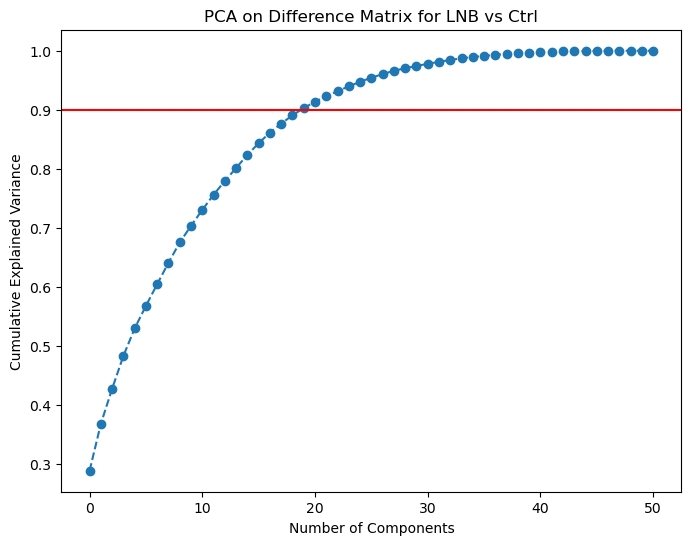


Comparison: LNB vs Ctrl

Number of Principal Components that explain 90% of the variance: 20



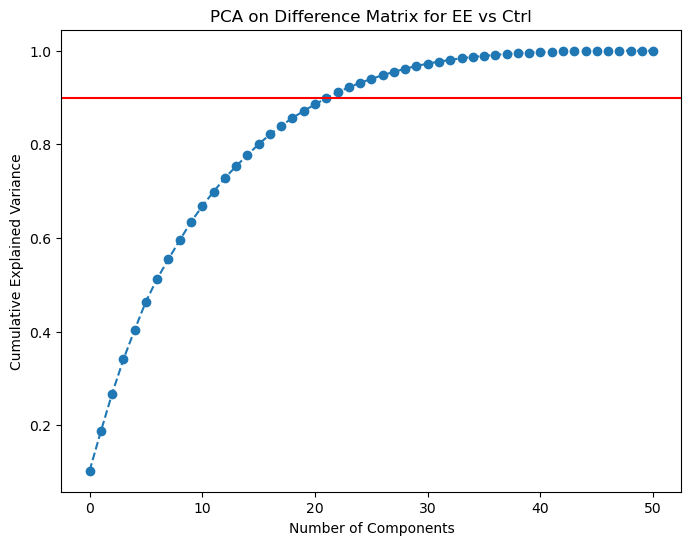


Comparison: EE vs Ctrl

Number of Principal Components that explain 90% of the variance: 23



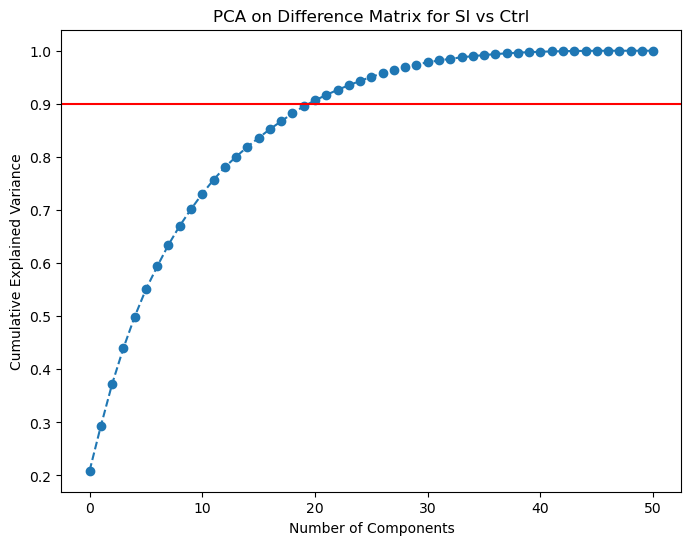


Comparison: SI vs Ctrl

Number of Principal Components that explain 90% of the variance: 21



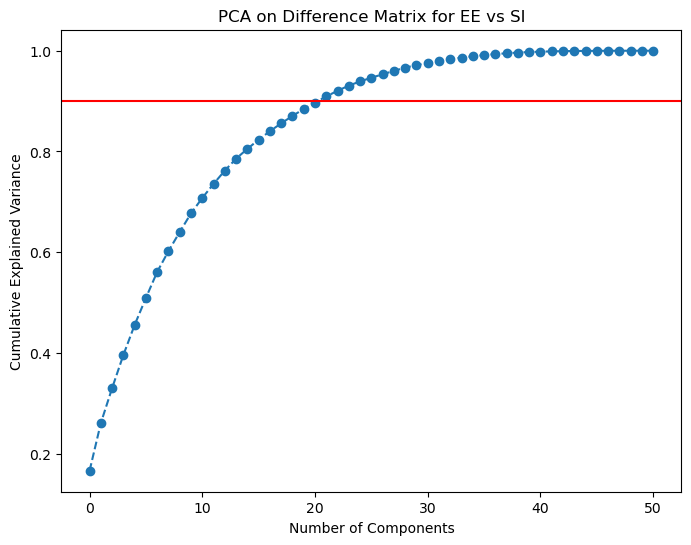


Comparison: EE vs SI

Number of Principal Components that explain 90% of the variance: 22



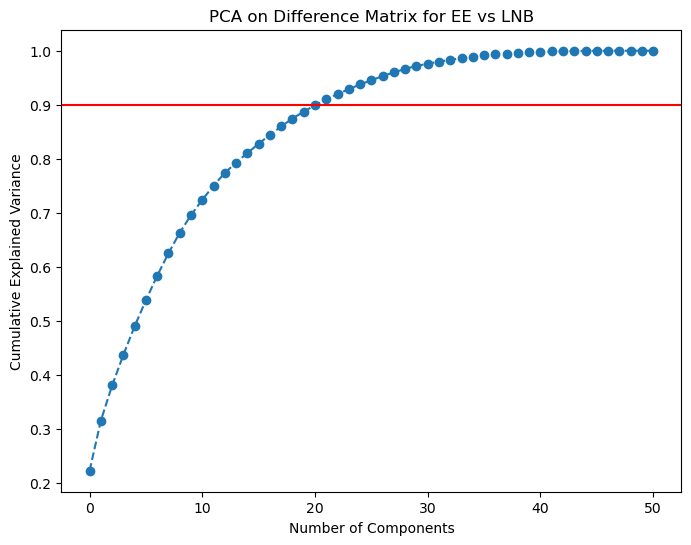


Comparison: EE vs LNB

Number of Principal Components that explain 90% of the variance: 22



In [144]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'comparisons' is a list of tuples with (mat1, mat2)
for mat1, mat2 in comparisons:

    A = females[mat1]
    B = females[mat2]

    # Step 1: Calculate the Difference Matrix
    difference_matrix = A - B
    
    # Step 2: Perform PCA on the Difference Matrix
    # Flatten the difference matrix (if needed)
    difference_matrix_flattened = difference_matrix.reshape(difference_matrix.shape[0], -1)
    
    # Initialize PCA
    pca = PCA()
    
    # Fit the PCA on the flattened difference matrix
    pca.fit(difference_matrix_flattened)
    
    # Step 3: Analyze Principal Components
    # Variance explained by each principal component
    explained_variance = pca.explained_variance_ratio_
    
    # Step 4: Calculate the number of PCs that explain 90% of the variance
    cumulative_explained_variance = np.cumsum(explained_variance)
    num_pcs_for_90_variance = np.argmax(cumulative_explained_variance >= 0.9) + 1
    
    # Plotting the explained variance
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
    plt.axhline(y=0.9, color='r', linestyle='-')  # Line at 90% explained variance
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'PCA on Difference Matrix for {mat1} vs {mat2}')
    plt.show()
    
    # Display the principal components and explained variance
    print(f"\nComparison: {mat1} vs {mat2}")
    
    print(f"\nNumber of Principal Components that explain 90% of the variance: {num_pcs_for_90_variance}\n")


## Stats (old)

In [2]:
EE_NormalF_Tsn = pd.read_csv('/om/scratch/Sun/mabdel03/Moseq/Redo_3/moseq_data/models/model-014-8858668/EE_Normal_Female_rows_transition_matrix.csv')

In [ ]:
EE_NormalF_Tsn

In [3]:
LNB_NormalF_Tsn = pd.read_csv('/om/scratch/Sun/mabdel03/Moseq/Redo_3/moseq_data/models/model-014-8858668/LNB_Mom_Female_rows_transition_matrix.csv')

In [ ]:
LNB_NormalF_Tsn

In [6]:
from sklearn.utils import shuffle
import numpy as np

def matrix_difference(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

def permutation_test(matrix1, matrix2, n_permutations=10000):
    observed_diff = matrix_difference(matrix1, matrix2)
    permuted_diffs = []

    for _ in range(n_permutations):
        permuted_matrix = shuffle(matrix2, random_state=0)
        permuted_diff = matrix_difference(matrix1, permuted_matrix)
        permuted_diffs.append(permuted_diff)

    p_value = np.mean(permuted_diffs >= observed_diff)
    return observed_diff, p_value


In [7]:
observed_diff, p_value = permutation_test(EE_NormalF_Tsn.to_numpy(), LNB_NormalF_Tsn.to_numpy())
print(f"Observed Difference: {observed_diff}, p-value: {p_value}")

Observed Difference: 34.857439387769574, p-value: 1.0


In [8]:
# Assuming df1 and df2 are flattened into vectors and combined into a DataFrame
df1 = EE_NormalF_Tsn.copy()
df2 = LNB_NormalF_Tsn.copy()

from scipy.stats import ttest_rel

t_statistic, p_value = ttest_rel(df1.to_numpy().flatten(), df2.to_numpy().flatten())
print(f"Paired T-test Statistic: {t_statistic}, p-value: {p_value}")

Paired T-test Statistic: -8.835324528487136e-17, p-value: 1.0


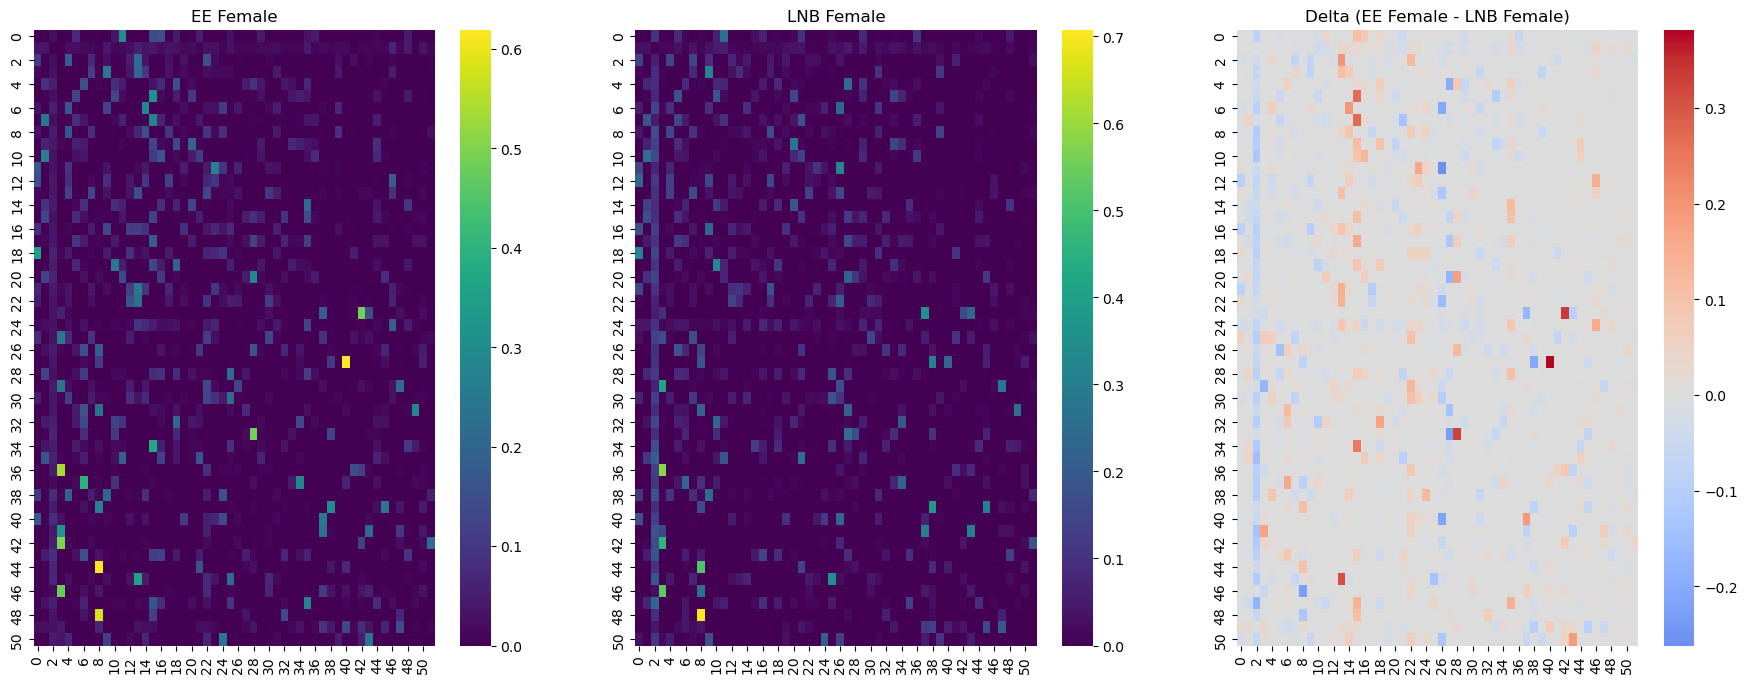

In [16]:
matrix1 = EE_NormalF_Tsn.to_numpy() 
matrix2 = LNB_NormalF_Tsn.to_numpy()

# Compute the difference (delta) matrix
delta_matrix = matrix1 - matrix2

# Plot the matrices side by side and the delta matrix
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

sns.heatmap(matrix1, ax=axes[0], cmap="viridis")
axes[0].set_title('EE Female')

sns.heatmap(matrix2, ax=axes[1], cmap="viridis")
axes[1].set_title('LNB Female')

sns.heatmap(delta_matrix, ax=axes[2], cmap="coolwarm", center=0)
axes[2].set_title('Delta (EE Female - LNB Female)')

plt.show()
